# Uplift Modeling — Lenta Dataset

Training and comparison of uplift models using scikit-uplift + CatBoost.

**Models:**
1. S-Learner (dummy)
2. S-Learner (treatment interaction)
3. T-Learner (vanilla)
4. T-Learner (DDR control)
5. Class Transformation

## 1. Setup & Data Loading

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load processed data
X_train = pd.read_csv('data/processed/X_train.csv')
X_test = pd.read_csv('data/processed/X_test.csv')
y_train = pd.read_csv('data/processed/y_train.csv').squeeze()
y_test = pd.read_csv('data/processed/y_test.csv').squeeze()
treatment_train = pd.read_csv('data/processed/treatment_train.csv').squeeze()
treatment_test = pd.read_csv('data/processed/treatment_test.csv').squeeze()

# Convert treatment: 'test' -> 1, 'control' -> 0
treatment_train = (treatment_train == 'test').astype(int)
treatment_test = (treatment_test == 'test').astype(int)

# Sanity checks
print(f'X_train: {X_train.shape}, X_test: {X_test.shape}')
print(f'Treatment rate — train: {treatment_train.mean():.3f}, test: {treatment_test.mean():.3f}')
print(f'Conversion rate — train: {y_train.mean():.4f}, test: {y_test.mean():.4f}')
print(f'Treatment dtypes: train={treatment_train.dtype}, test={treatment_test.dtype}')

def asd_score(y_true, uplift_pred, treatment, n_bins=10):
    """Average Squared Deviation (calibration metric).
    Splits customers into n_bins deciles by predicted uplift, computes
    actual uplift per decile, returns mean((actual - predicted)^2).
    Lower = better calibrated.
    """
    df = pd.DataFrame({'y': np.asarray(y_true),
                       'uplift': np.asarray(uplift_pred),
                       'treatment': np.asarray(treatment)})
    df['decile'] = pd.qcut(df['uplift'].rank(method='first'), q=n_bins,
                            labels=False, duplicates='drop')
    sq = []
    for _, grp in df.groupby('decile'):
        trt  = grp[grp['treatment'] == 1]['y']
        ctrl = grp[grp['treatment'] == 0]['y']
        if len(trt) == 0 or len(ctrl) == 0:
            continue
        sq.append((trt.mean() - ctrl.mean() - grp['uplift'].mean()) ** 2)
    return np.mean(sq) if sq else np.nan


## 2. Fix sklift.viz compatibility

sklearn 1.8 moved `check_matplotlib_support` to `sklearn.utils._plotting`. Patch at runtime.

In [2]:
import sklearn.utils
from sklearn.utils._plotting import check_matplotlib_support
sklearn.utils.check_matplotlib_support = check_matplotlib_support

from sklift.viz import plot_qini_curve, plot_uplift_curve
from sklift.metrics import (
    uplift_at_k, qini_auc_score, uplift_auc_score,
    weighted_average_uplift, qini_curve, uplift_curve,
    perfect_qini_curve, perfect_uplift_curve
)
from sklift.models import SoloModel, TwoModels, ClassTransformation

print('sklift imports OK')

sklift imports OK


## 3. Baseline: Random Model

In [ ]:
np.random.seed(42)
uplift_random = np.random.uniform(-0.1, 0.1, size=len(y_test))

print('Random baseline metrics:')
print(f"  uplift@30%: {uplift_at_k(y_test, uplift_random, treatment_test, strategy='by_group', k=0.3):.4f}")
print(f"  Qini AUC:   {qini_auc_score(y_test, uplift_random, treatment_test):.4f}")
print(f"  Uplift AUC: {uplift_auc_score(y_test, uplift_random, treatment_test):.4f}")
print(f"  ASD:        {asd_score(y_test, uplift_random, treatment_test):.6f}")

## 4. Train Uplift Models

In [4]:
from catboost import CatBoostClassifier

def make_catboost():
    return CatBoostClassifier(
        iterations=200, depth=6, learning_rate=0.1,
        random_state=42, silent=True
    )

models = {}
predictions = {}

### 4.1 S-Learner (dummy)

In [5]:
%%time
sm_dummy = SoloModel(estimator=make_catboost(), method='dummy')
sm_dummy.fit(X_train, y_train, treatment_train)
predictions['S-Learner (dummy)'] = sm_dummy.predict(X_test)
models['S-Learner (dummy)'] = sm_dummy
print('S-Learner (dummy) done')

S-Learner (dummy) done
CPU times: user 1min 49s, sys: 3.91 s, total: 1min 53s
Wall time: 16.6 s


### 4.2 S-Learner (treatment interaction)

In [6]:
%%time
sm_interaction = SoloModel(estimator=make_catboost(), method='treatment_interaction')
sm_interaction.fit(X_train, y_train, treatment_train)
predictions['S-Learner (interaction)'] = sm_interaction.predict(X_test)
models['S-Learner (interaction)'] = sm_interaction
print('S-Learner (interaction) done')

S-Learner (interaction) done
CPU times: user 3min 9s, sys: 5.54 s, total: 3min 15s
Wall time: 29.6 s


### 4.3 T-Learner (vanilla)

In [7]:
%%time
tm_vanilla = TwoModels(
    estimator_trmnt=make_catboost(),
    estimator_ctrl=make_catboost(),
    method='vanilla'
)
tm_vanilla.fit(X_train, y_train, treatment_train)
predictions['T-Learner'] = tm_vanilla.predict(X_test)
models['T-Learner'] = tm_vanilla
print('T-Learner (vanilla) done')

T-Learner (vanilla) done
CPU times: user 2min 2s, sys: 5.57 s, total: 2min 7s
Wall time: 18.7 s


### 4.4 T-Learner (DDR control)

In [8]:
%%time
tm_ddr = TwoModels(
    estimator_trmnt=make_catboost(),
    estimator_ctrl=make_catboost(),
    method='ddr_control'
)
tm_ddr.fit(X_train, y_train, treatment_train)
predictions['T-Learner (DDR)'] = tm_ddr.predict(X_test)
models['T-Learner (DDR)'] = tm_ddr
print('T-Learner (DDR control) done')

T-Learner (DDR control) done
CPU times: user 2min 5s, sys: 5.62 s, total: 2min 11s
Wall time: 19.3 s


### 4.5 Class Transformation

In [9]:
%%time
ct = ClassTransformation(estimator=make_catboost())
ct.fit(X_train, y_train, treatment_train)
predictions['Class Transformation'] = ct.predict(X_test)
models['Class Transformation'] = ct
print('Class Transformation done')

Class Transformation done
CPU times: user 1min 55s, sys: 3.89 s, total: 1min 59s
Wall time: 17.4 s


## 5. Evaluation & Comparison

In [ ]:
# Add random baseline to predictions for comparison
all_predictions = {'Random': uplift_random, **predictions}

results = []
for name, uplift_pred in all_predictions.items():
    results.append({
        'Model': name,
        'uplift@10%': uplift_at_k(y_test, uplift_pred, treatment_test, strategy='by_group', k=0.1),
        'uplift@30%': uplift_at_k(y_test, uplift_pred, treatment_test, strategy='by_group', k=0.3),
        'Qini AUC': qini_auc_score(y_test, uplift_pred, treatment_test),
        'Uplift AUC': uplift_auc_score(y_test, uplift_pred, treatment_test),
        'WAU': weighted_average_uplift(y_test, uplift_pred, treatment_test, strategy='by_group', bins=10),
        'ASD': asd_score(y_test, uplift_pred, treatment_test),
    })

results_df = pd.DataFrame(results).set_index('Model')
results_df.style.format('{:.4f}').highlight_max(axis=0, color='lightgreen')

### 5.1 Train vs Test comparison

In [ ]:
# Predictions on train set
train_predictions = {name: model.predict(X_train) for name, model in models.items()}

# Metrics on train
train_results = []
for name, uplift_pred in train_predictions.items():
    train_results.append({
        'Model': name,
        'uplift@10%': uplift_at_k(y_train, uplift_pred, treatment_train, strategy='by_group', k=0.1),
        'uplift@30%': uplift_at_k(y_train, uplift_pred, treatment_train, strategy='by_group', k=0.3),
        'Qini AUC':   qini_auc_score(y_train, uplift_pred, treatment_train),
        'Uplift AUC': uplift_auc_score(y_train, uplift_pred, treatment_train),
        'ASD':        asd_score(y_train, uplift_pred, treatment_train),
    })

train_df = pd.DataFrame(train_results).set_index('Model')
test_df  = results_df.drop(index='Random')[['uplift@10%', 'uplift@30%', 'Qini AUC', 'Uplift AUC', 'ASD']]

# Side-by-side comparison
comparison = pd.concat(
    [train_df.add_suffix(' (Train)'), test_df.add_suffix(' (Test)')],
    axis=1
).sort_index(axis=1)  # interleave columns alphabetically

# Reorder columns for readability
cols_order = []
for metric in ['Qini AUC', 'Uplift AUC', 'ASD', 'uplift@10%', 'uplift@30%']:
    cols_order += [f'{metric} (Train)', f'{metric} (Test)']
comparison = comparison[cols_order]

print('=== Train vs Test metrics ===\n')
print(comparison.to_string(float_format='{:.4f}'.format))

# Highlight overfitting: Train - Test delta
print('\n=== Delta (Train − Test) — positive = overfitting ===\n')
delta = train_df - test_df
print(delta.to_string(float_format='{:+.4f}'.format))

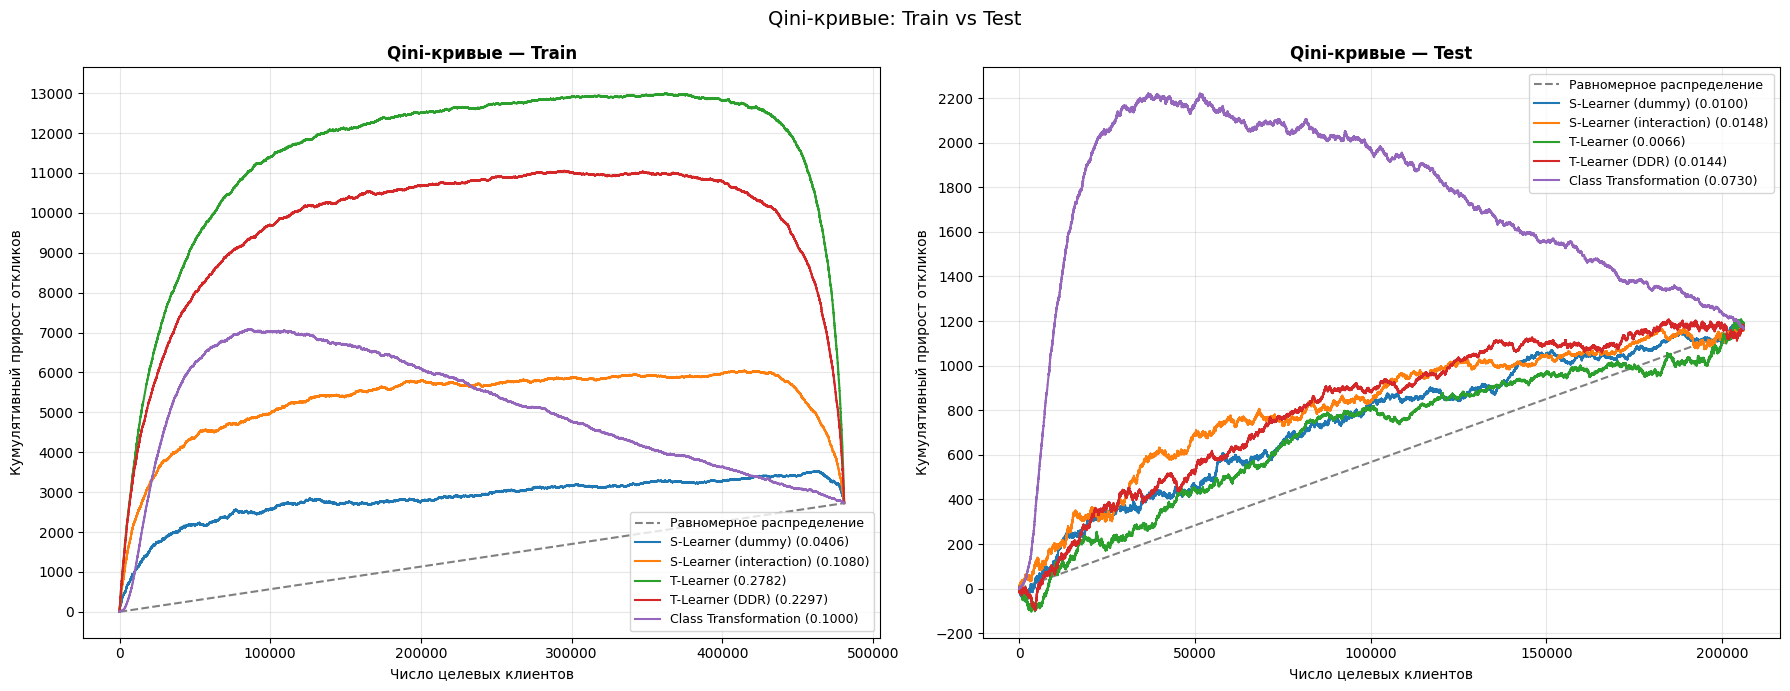

In [12]:
model_colors = {
    'S-Learner (dummy)':       '#1f77b4',
    'S-Learner (interaction)': '#ff7f0e',
    'T-Learner':               '#2ca02c',
    'T-Learner (DDR)':         '#d62728',
    'Class Transformation':    '#9467bd',
}

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

for ax, (split, preds, y, trt) in zip(axes, [
    ('Train', train_predictions, y_train, treatment_train),
    ('Test',  predictions,       y_test,  treatment_test),
]):
    for name, color in model_colors.items():
        x_vals, y_vals = qini_curve(y, preds[name], trt)
        if name == list(model_colors.keys())[0]:
            ax.plot([0, x_vals[-1]], [0, y_vals[-1]],
                    color='gray', linestyle='--', linewidth=1.5, label='Равномерное распределение')
        auc = qini_auc_score(y, preds[name], trt)
        ax.plot(x_vals, y_vals, color=color, linewidth=1.5, label=f'{name} ({auc:.4f})')

    ax.set_title(f'Qini-кривые — {split}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Число целевых клиентов')
    ax.set_ylabel('Кумулятивный прирост откликов')
    ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=15))
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Qini-кривые: Train vs Test', fontsize=14)
plt.tight_layout()
plt.show()

## 6. Visualization

### 6.0 Distribution of Predicted Probabilities (P(treatment), P(control), Uplift)

Гистограммы условных вероятностей P(Y=1|T=1) и P(Y=1|T=0), а также их разности (uplift) для каждой модели.
Доступно только для S-Learner и T-Learner (ClassTransformation не выдаёт раздельные вероятности).

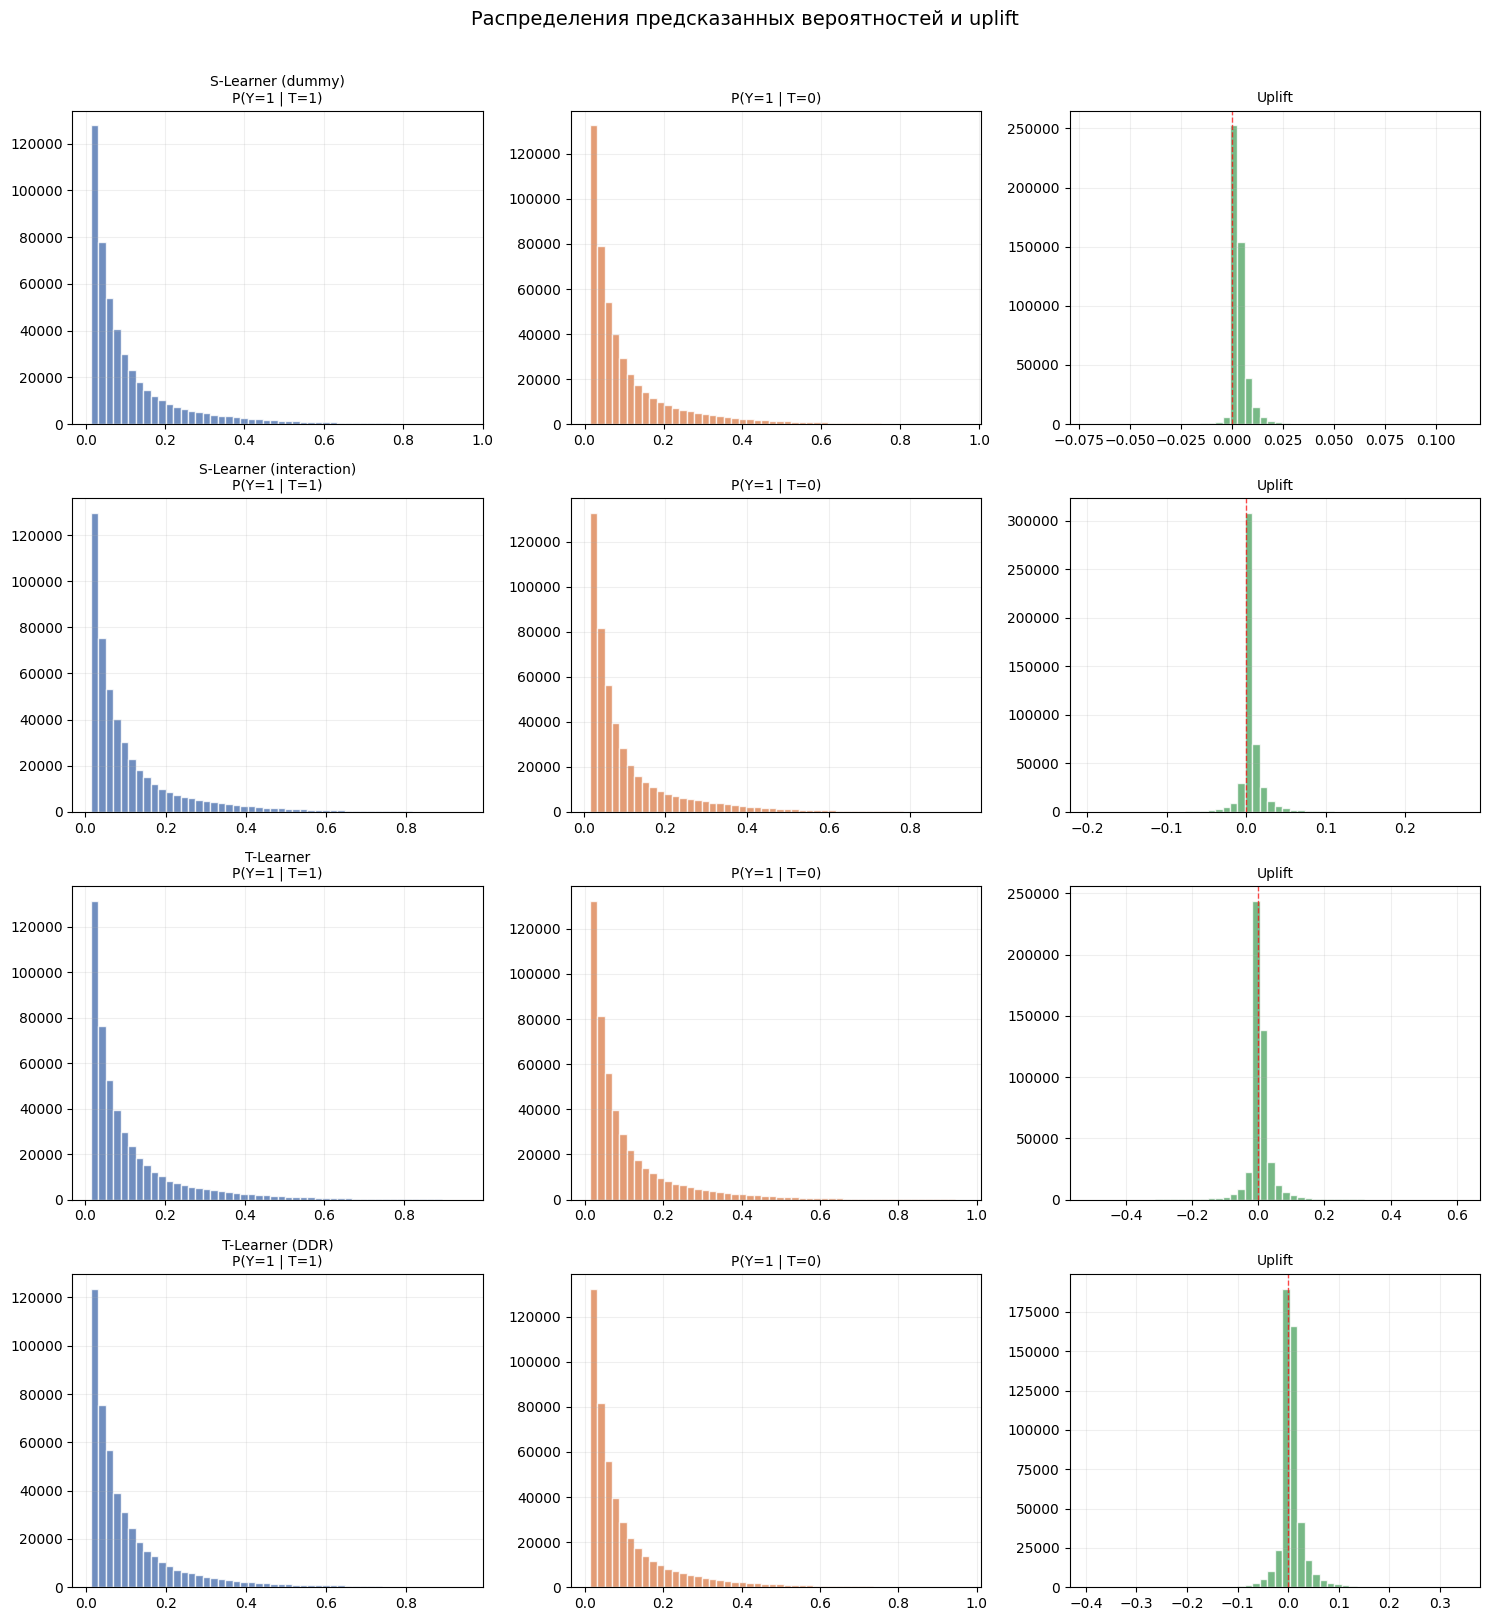

In [13]:
from sklift.viz import plot_uplift_preds

# Models with separate treatment/control predictions
preds_models = {
    'S-Learner (dummy)': models['S-Learner (dummy)'],
    'S-Learner (interaction)': models['S-Learner (interaction)'],
    'T-Learner': models['T-Learner'],
    'T-Learner (DDR)': models['T-Learner (DDR)'],
}

fig, axes = plt.subplots(len(preds_models), 3, figsize=(15, 4 * len(preds_models)))

for row, (name, model) in enumerate(preds_models.items()):
    trmnt_preds = model.trmnt_preds_
    ctrl_preds = model.ctrl_preds_
    uplift_pred = trmnt_preds - ctrl_preds

    for col, (data_arr, title, color) in enumerate([
        (trmnt_preds, 'P(Y=1 | T=1)', '#4C72B0'),
        (ctrl_preds, 'P(Y=1 | T=0)', '#DD8452'),
        (uplift_pred, 'Uplift', '#55A868'),
    ]):
        ax = axes[row, col]
        ax.hist(data_arr, bins=50, color=color, edgecolor='white', alpha=0.8)
        if col == 2:
            ax.axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.7)
        ax.set_title(f'{name}\n{title}' if col == 0 else title, fontsize=10)
        ax.set_xlabel('')
        ax.grid(True, alpha=0.2)

plt.suptitle('Распределения предсказанных вероятностей и uplift', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

### 6.1 Qini Curves

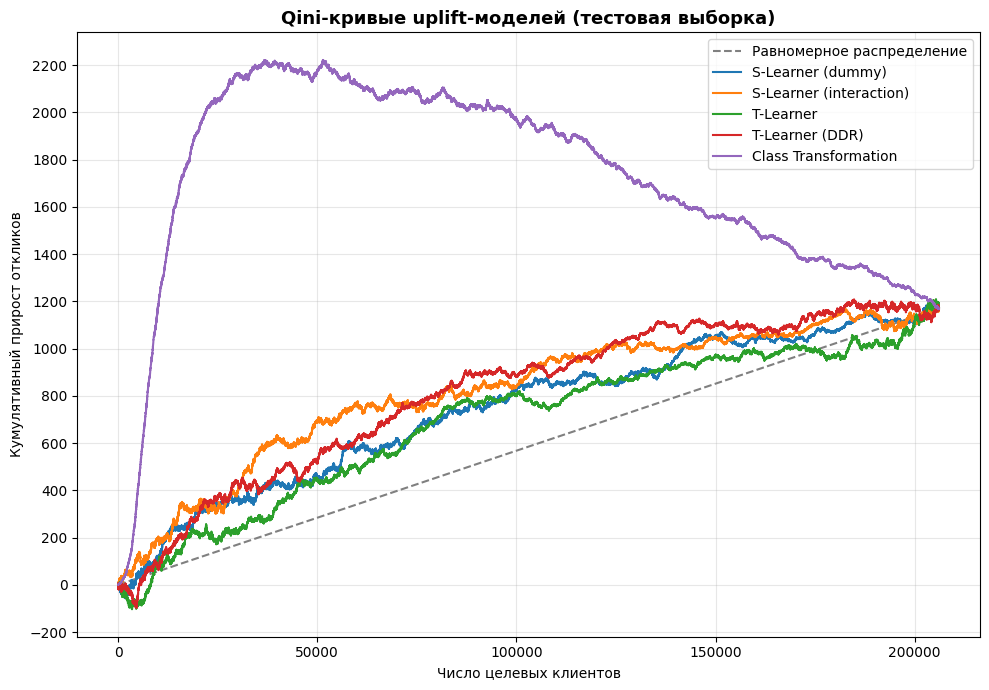

In [14]:
model_colors = {
    'S-Learner (dummy)':       '#1f77b4',  # blue
    'S-Learner (interaction)': '#ff7f0e',  # orange
    'T-Learner':               '#2ca02c',  # green
    'T-Learner (DDR)':         '#d62728',  # red
    'Class Transformation':    '#9467bd',  # purple
}

fig, ax = plt.subplots(figsize=(10, 7))

for name, color in model_colors.items():
    x_vals, y_vals = qini_curve(y_test, predictions[name], treatment_test)
    if name == list(model_colors.keys())[0]:
        ax.plot([0, x_vals[-1]], [0, y_vals[-1]],
                color='gray', linestyle='--', linewidth=1.5, label='Равномерное распределение')
    ax.plot(x_vals, y_vals, color=color, linewidth=1.5, label=name)

ax.set_title('Qini-кривые uplift-моделей (тестовая выборка)', fontsize=13, fontweight='bold')
ax.set_xlabel('Число целевых клиентов')
ax.set_ylabel('Кумулятивный прирост откликов')
ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=15))
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 6.2 Uplift Curves

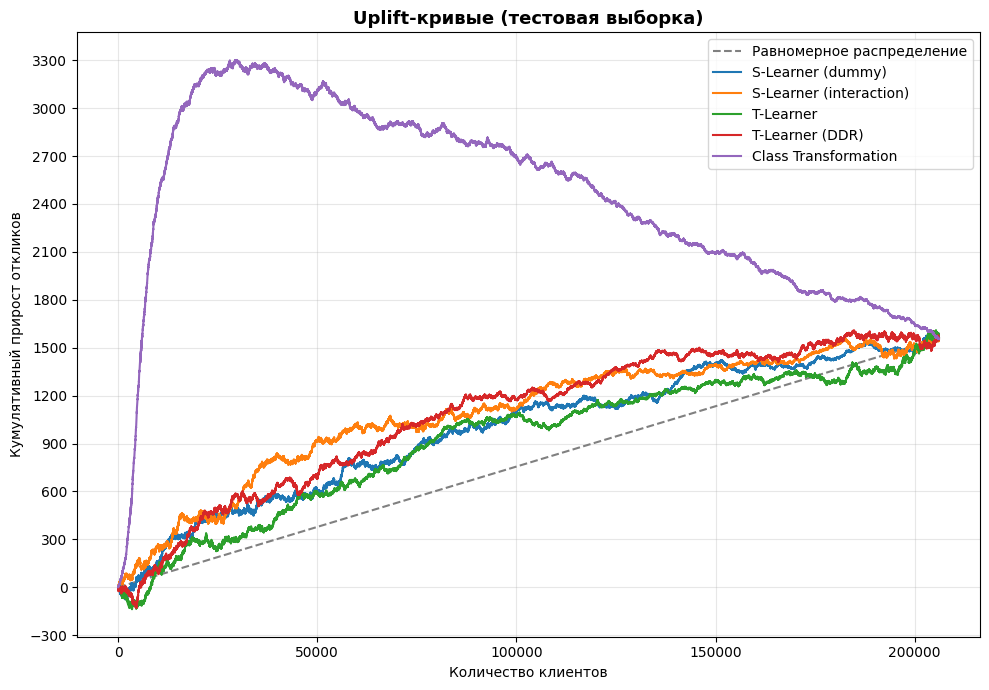

In [15]:
model_colors = {
    'S-Learner (dummy)':       '#1f77b4',  # blue
    'S-Learner (interaction)': '#ff7f0e',  # orange
    'T-Learner':               '#2ca02c',  # green
    'T-Learner (DDR)':         '#d62728',  # red
    'Class Transformation':    '#9467bd',  # purple
}

fig, ax = plt.subplots(figsize=(10, 7))

for name, color in model_colors.items():
    x_vals, y_vals = uplift_curve(y_test, predictions[name], treatment_test)
    if name == list(model_colors.keys())[0]:
        ax.plot([0, x_vals[-1]], [0, y_vals[-1]],
                color='gray', linestyle='--', linewidth=1.5, label='Равномерное распределение')
    ax.plot(x_vals, y_vals, color=color, linewidth=1.5, label=name)

ax.set_title('Uplift-кривые (тестовая выборка)', fontsize=13, fontweight='bold')
ax.set_xlabel('Количество клиентов')
ax.set_ylabel('Кумулятивный прирост откликов')
ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=15))
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 6.1b Qini Curves — individual canvas per model

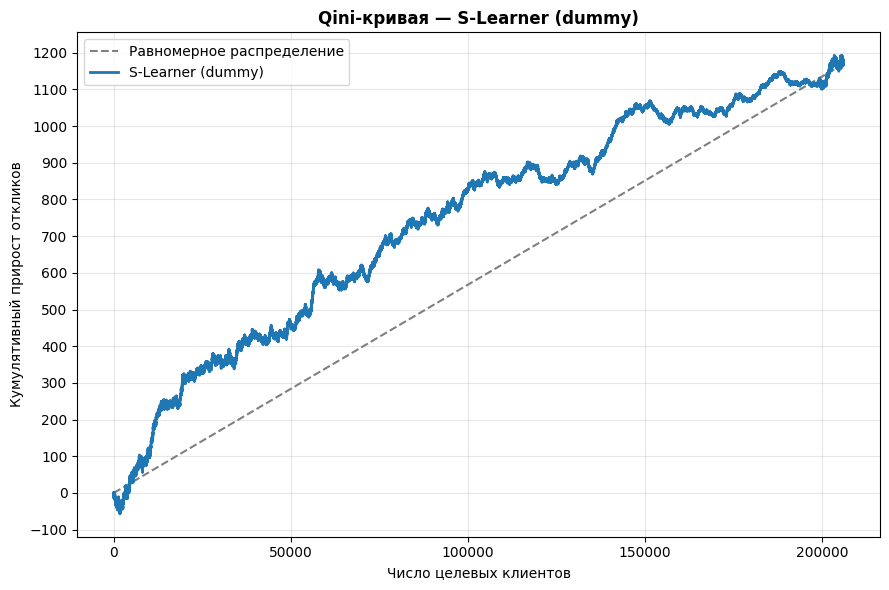

In [16]:
name = 'S-Learner (dummy)'
color = '#1f77b4'  # blue

x_vals, y_vals = qini_curve(y_test, predictions[name], treatment_test)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot([0, x_vals[-1]], [0, y_vals[-1]], color='gray', linestyle='--', linewidth=1.5, label='Равномерное распределение')
ax.plot(x_vals, y_vals, color=color, linewidth=2, label=name)
ax.set_title(f'Qini-кривая — {name}', fontsize=12, fontweight='bold')
ax.set_xlabel('Число целевых клиентов')
ax.set_ylabel('Кумулятивный прирост откликов')
ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=15))
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

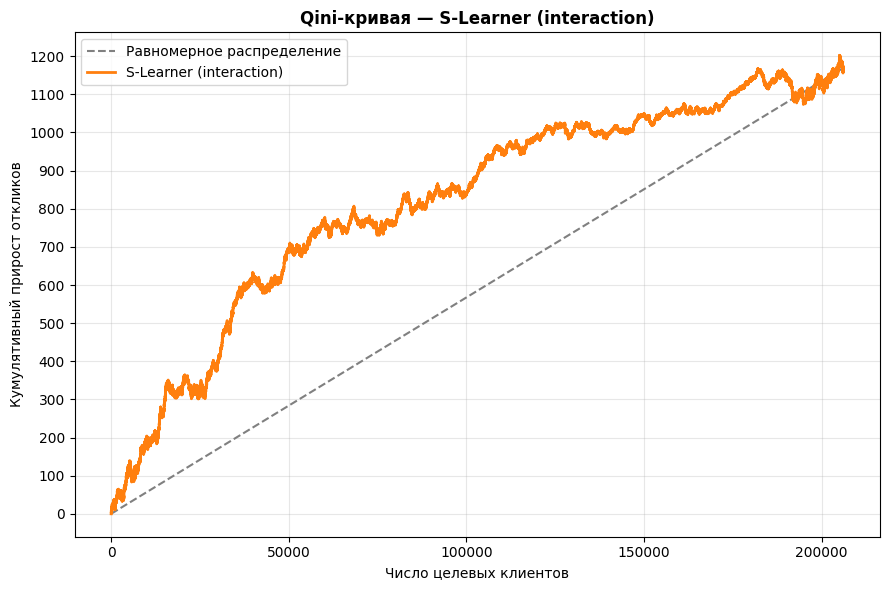

In [17]:
name = 'S-Learner (interaction)'
color = '#ff7f0e'  # orange

x_vals, y_vals = qini_curve(y_test, predictions[name], treatment_test)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot([0, x_vals[-1]], [0, y_vals[-1]], color='gray', linestyle='--', linewidth=1.5, label='Равномерное распределение')
ax.plot(x_vals, y_vals, color=color, linewidth=2, label=name)
ax.set_title(f'Qini-кривая — {name}', fontsize=12, fontweight='bold')
ax.set_xlabel('Число целевых клиентов')
ax.set_ylabel('Кумулятивный прирост откликов')
ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=15))
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

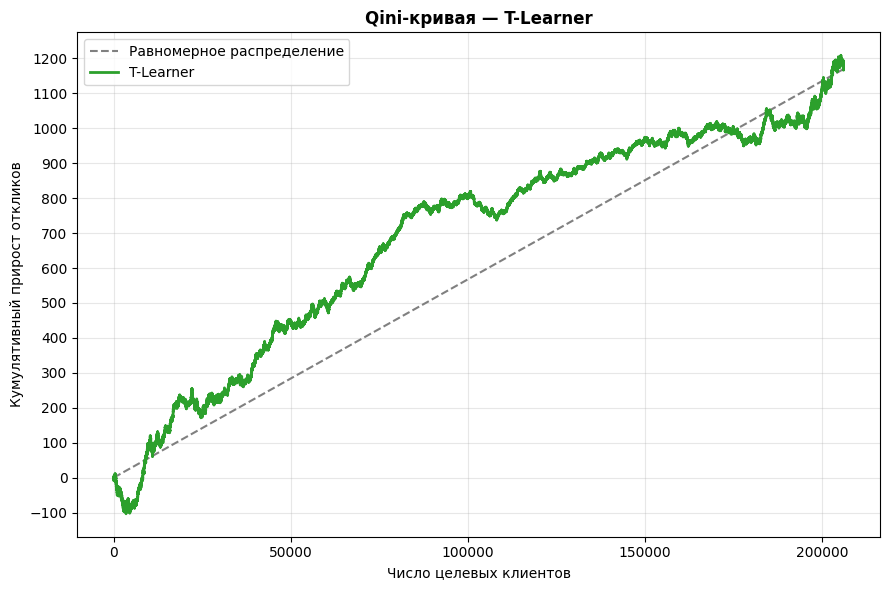

In [18]:
name = 'T-Learner'
color = '#2ca02c'  # green

x_vals, y_vals = qini_curve(y_test, predictions[name], treatment_test)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot([0, x_vals[-1]], [0, y_vals[-1]], color='gray', linestyle='--', linewidth=1.5, label='Равномерное распределение')
ax.plot(x_vals, y_vals, color=color, linewidth=2, label=name)
ax.set_title(f'Qini-кривая — {name}', fontsize=12, fontweight='bold')
ax.set_xlabel('Число целевых клиентов')
ax.set_ylabel('Кумулятивный прирост откликов')
ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=15))
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

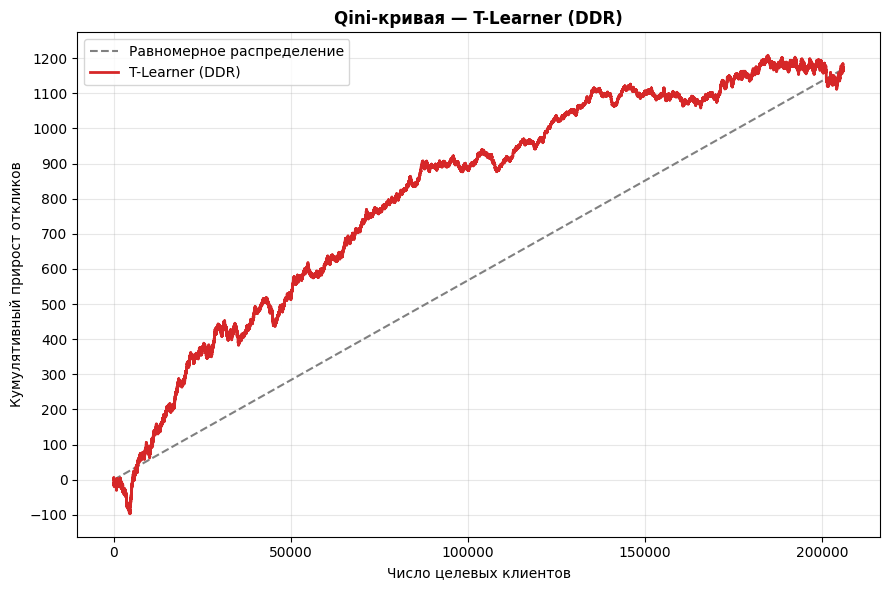

In [19]:
name = 'T-Learner (DDR)'
color = '#d62728'  # red

x_vals, y_vals = qini_curve(y_test, predictions[name], treatment_test)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot([0, x_vals[-1]], [0, y_vals[-1]], color='gray', linestyle='--', linewidth=1.5, label='Равномерное распределение')
ax.plot(x_vals, y_vals, color=color, linewidth=2, label=name)
ax.set_title(f'Qini-кривая — {name}', fontsize=12, fontweight='bold')
ax.set_xlabel('Число целевых клиентов')
ax.set_ylabel('Кумулятивный прирост откликов')
ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=15))
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

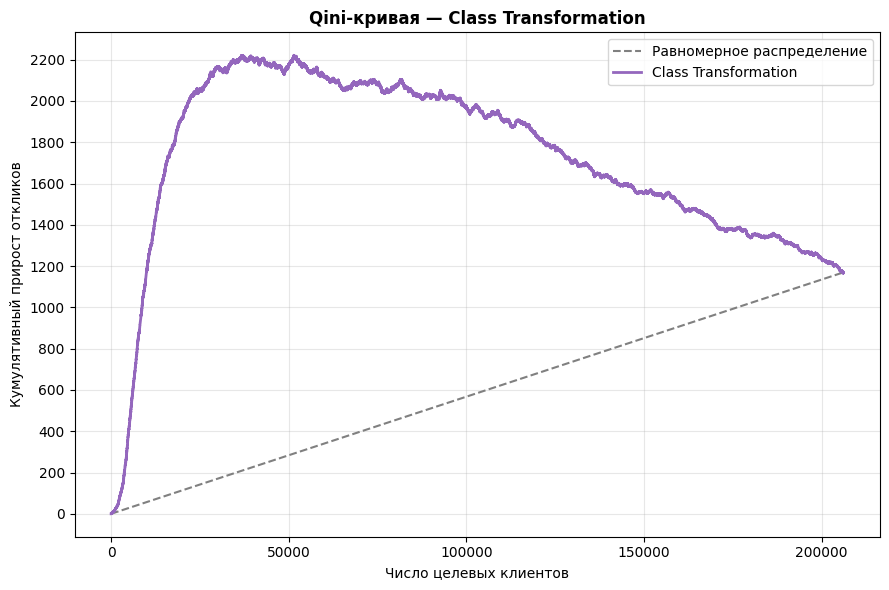

In [20]:
name = 'Class Transformation'
color = '#9467bd'  # purple

x_vals, y_vals = qini_curve(y_test, predictions[name], treatment_test)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot([0, x_vals[-1]], [0, y_vals[-1]], color='gray', linestyle='--', linewidth=1.5, label='Равномерное распределение')
ax.plot(x_vals, y_vals, color=color, linewidth=2, label=name)
ax.set_title(f'Qini-кривая — {name}', fontsize=12, fontweight='bold')
ax.set_xlabel('Число целевых клиентов')
ax.set_ylabel('Кумулятивный прирост откликов')
ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=15))
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 6.2b Uplift Curves — individual canvas per model

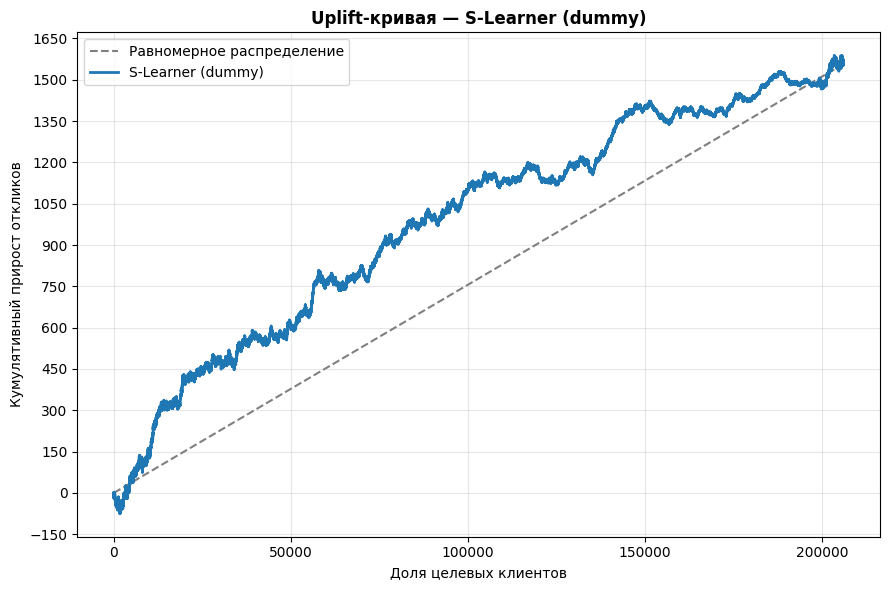

In [21]:
name = 'S-Learner (dummy)'
color = '#1f77b4'  # blue

x_vals, y_vals = uplift_curve(y_test, predictions[name], treatment_test)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot([0, x_vals[-1]], [0, y_vals[-1]], color='gray', linestyle='--', linewidth=1.5, label='Равномерное распределение')
ax.plot(x_vals, y_vals, color=color, linewidth=2, label=name)
ax.set_title(f'Uplift-кривая — {name}', fontsize=12, fontweight='bold')
ax.set_xlabel('Доля целевых клиентов')
ax.set_ylabel('Кумулятивный прирост откликов')
ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=15))
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

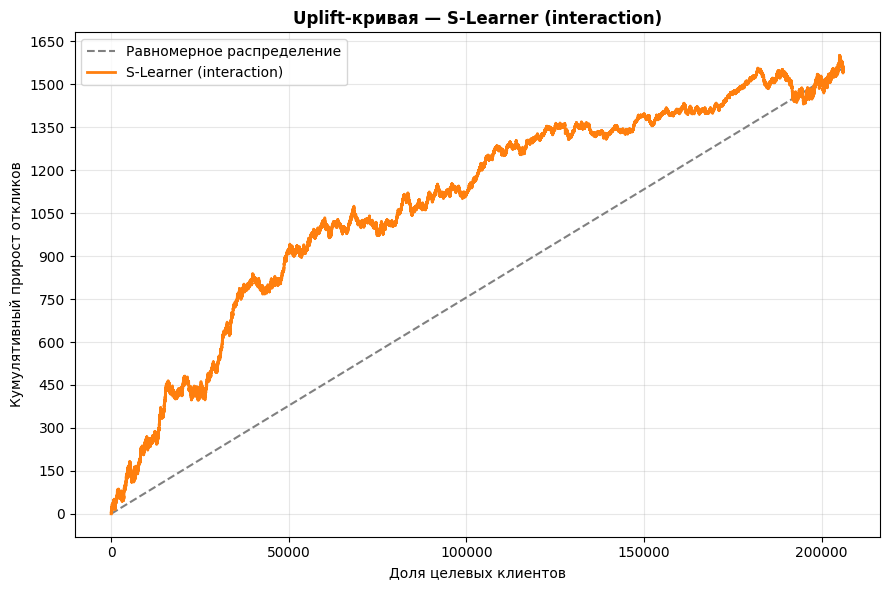

In [22]:
name = 'S-Learner (interaction)'
color = '#ff7f0e'  # orange

x_vals, y_vals = uplift_curve(y_test, predictions[name], treatment_test)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot([0, x_vals[-1]], [0, y_vals[-1]], color='gray', linestyle='--', linewidth=1.5, label='Равномерное распределение')
ax.plot(x_vals, y_vals, color=color, linewidth=2, label=name)
ax.set_title(f'Uplift-кривая — {name}', fontsize=12, fontweight='bold')
ax.set_xlabel('Доля целевых клиентов')
ax.set_ylabel('Кумулятивный прирост откликов')
ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=15))
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

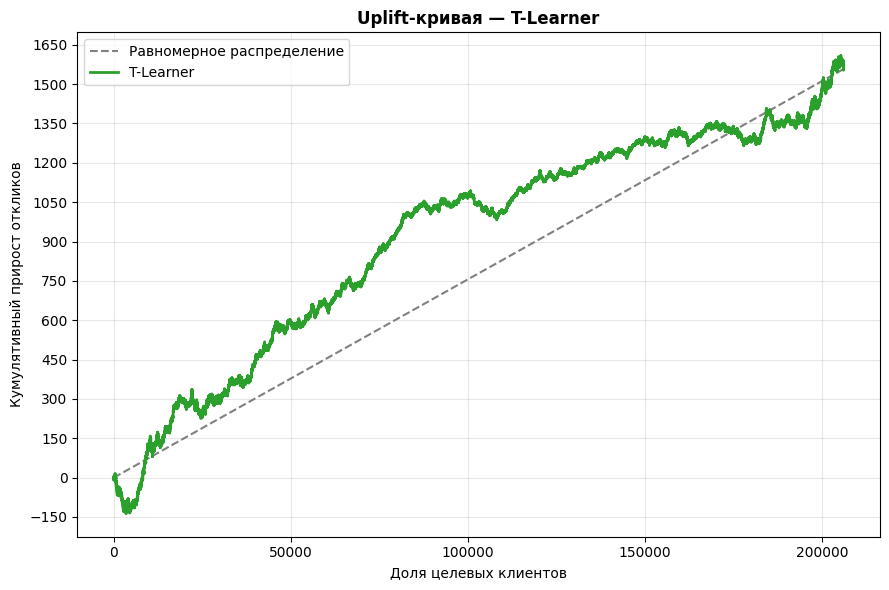

In [23]:
name = 'T-Learner'
color = '#2ca02c'  # green

x_vals, y_vals = uplift_curve(y_test, predictions[name], treatment_test)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot([0, x_vals[-1]], [0, y_vals[-1]], color='gray', linestyle='--', linewidth=1.5, label='Равномерное распределение')
ax.plot(x_vals, y_vals, color=color, linewidth=2, label=name)
ax.set_title(f'Uplift-кривая — {name}', fontsize=12, fontweight='bold')
ax.set_xlabel('Доля целевых клиентов')
ax.set_ylabel('Кумулятивный прирост откликов')
ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=15))
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

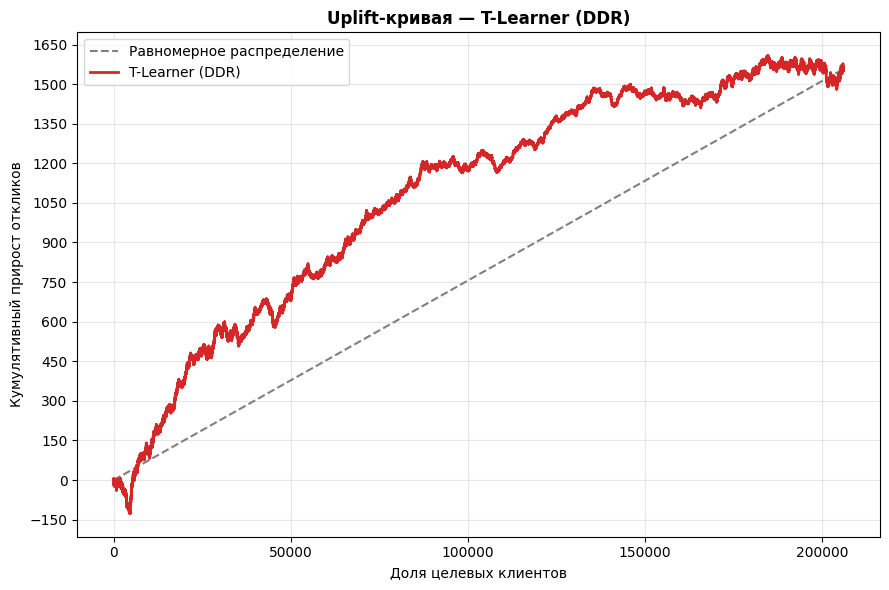

In [24]:
name = 'T-Learner (DDR)'
color = '#d62728'  # red

x_vals, y_vals = uplift_curve(y_test, predictions[name], treatment_test)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot([0, x_vals[-1]], [0, y_vals[-1]], color='gray', linestyle='--', linewidth=1.5, label='Равномерное распределение')
ax.plot(x_vals, y_vals, color=color, linewidth=2, label=name)
ax.set_title(f'Uplift-кривая — {name}', fontsize=12, fontweight='bold')
ax.set_xlabel('Доля целевых клиентов')
ax.set_ylabel('Кумулятивный прирост откликов')
ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=15))
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

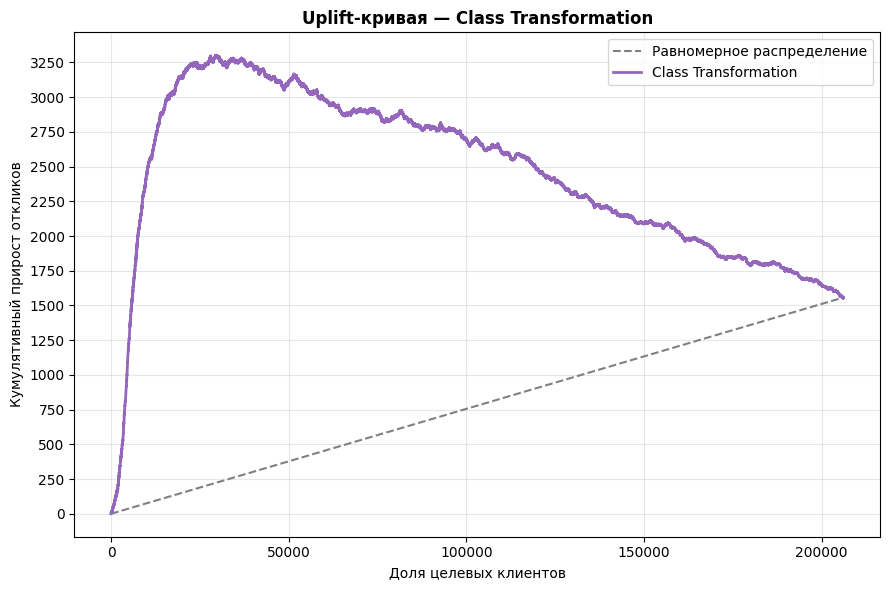

In [25]:
name = 'Class Transformation'
color = '#9467bd'  # purple

x_vals, y_vals = uplift_curve(y_test, predictions[name], treatment_test)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot([0, x_vals[-1]], [0, y_vals[-1]], color='gray', linestyle='--', linewidth=1.5, label='Равномерное распределение')
ax.plot(x_vals, y_vals, color=color, linewidth=2, label=name)
ax.set_title(f'Uplift-кривая — {name}', fontsize=12, fontweight='bold')
ax.set_xlabel('Доля целевых клиентов')
ax.set_ylabel('Кумулятивный прирост откликов')
ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=15))
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 6.3 Uplift by Percentile (Best Model)

Best model: Class Transformation


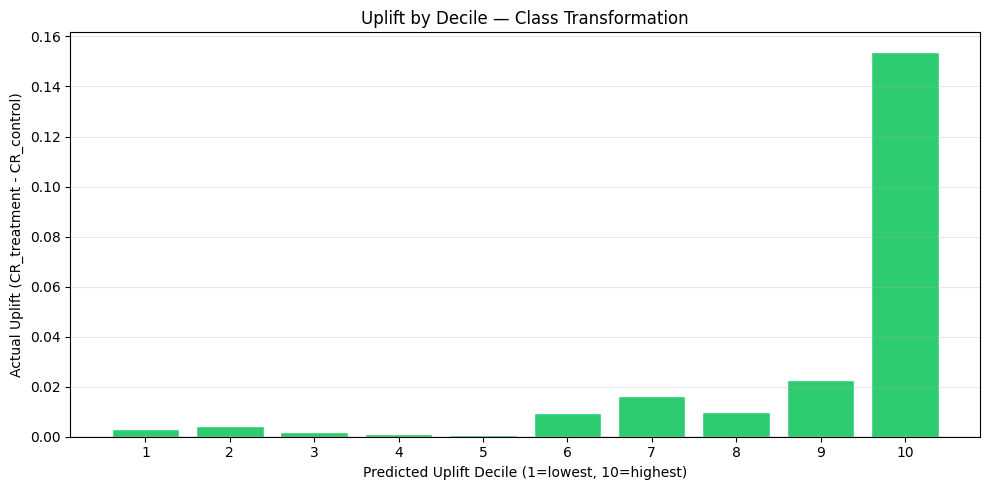

 Decile  CR treatment  CR control   Uplift
      1      0.019852    0.016953 0.002899
      2      0.027780    0.023617 0.004163
      3      0.035077    0.033032 0.002044
      4      0.047378    0.046225 0.001154
      5      0.064933    0.064243 0.000690
      6      0.083540    0.074143 0.009397
      7      0.112903    0.096447 0.016457
      8      0.156915    0.147023 0.009892
      9      0.229613    0.206994 0.022619
     10      0.380376    0.226422 0.153954


In [26]:
# Pick best model by Qini AUC
best_model_name = results_df.drop(index='Random')['Qini AUC'].idxmax()
best_uplift = predictions[best_model_name]
print(f'Best model: {best_model_name}')

# Compute uplift by decile
n_bins = 10
df_eval = pd.DataFrame({
    'uplift_pred': best_uplift,
    'y': y_test.values,
    'treatment': treatment_test.values
})
df_eval['bin'] = pd.qcut(df_eval['uplift_pred'], n_bins, labels=False, duplicates='drop')

bin_stats = []
for b in sorted(df_eval['bin'].unique()):
    subset = df_eval[df_eval['bin'] == b]
    cr_t = subset.loc[subset['treatment'] == 1, 'y'].mean()
    cr_c = subset.loc[subset['treatment'] == 0, 'y'].mean()
    bin_stats.append({'Decile': b + 1, 'CR treatment': cr_t, 'CR control': cr_c, 'Uplift': cr_t - cr_c})

bin_df = pd.DataFrame(bin_stats)

fig, ax = plt.subplots(figsize=(10, 5))
colors_bar = ['#2ecc71' if u > 0 else '#e74c3c' for u in bin_df['Uplift']]
ax.bar(bin_df['Decile'], bin_df['Uplift'], color=colors_bar, edgecolor='white')
ax.axhline(y=0, color='black', linewidth=0.8)
ax.set_xlabel('Predicted Uplift Decile (1=lowest, 10=highest)')
ax.set_ylabel('Actual Uplift (CR_treatment - CR_control)')
ax.set_title(f'Uplift by Decile — {best_model_name}')
ax.set_xticks(bin_df['Decile'])
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(bin_df.to_string(index=False))

### 6.4 Distribution of Predicted Uplift (Best Model)

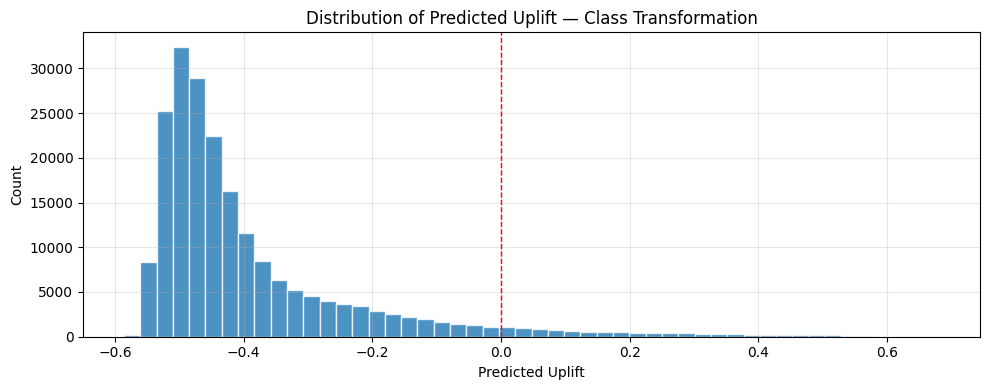

Mean: -0.3883, Std: 0.1758
Min: -0.5859, Max: 0.6813
% positive uplift: 4.8%


In [27]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(best_uplift, bins=50, edgecolor='white', alpha=0.8)
ax.axvline(x=0, color='red', linestyle='--', linewidth=1)
ax.set_xlabel('Predicted Uplift')
ax.set_ylabel('Count')
ax.set_title(f'Distribution of Predicted Uplift — {best_model_name}')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f'Mean: {best_uplift.mean():.4f}, Std: {best_uplift.std():.4f}')
print(f'Min: {best_uplift.min():.4f}, Max: {best_uplift.max():.4f}')
print(f'% positive uplift: {(best_uplift > 0).mean():.1%}')

## 7. Feature Importance (Best Model)

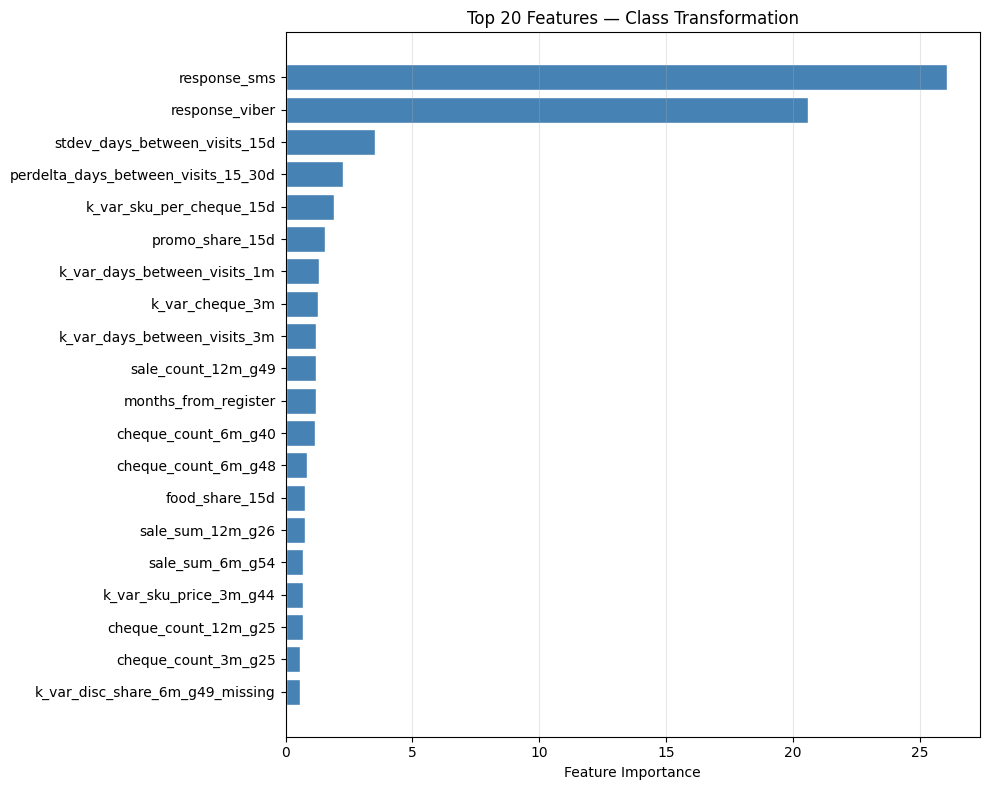

In [28]:
# Extract CatBoost estimator from the best model
best_sklift_model = models[best_model_name]

# Get the underlying CatBoost estimator(s)
if hasattr(best_sklift_model, 'estimator'):
    # SoloModel or ClassTransformation
    cb_model = best_sklift_model.estimator
    feature_names = X_train.columns.tolist()
    # SoloModel with treatment_interaction adds extra features
    if hasattr(cb_model, 'feature_names_') and cb_model.feature_names_:
        feature_names = list(cb_model.feature_names_)
    importances = cb_model.feature_importances_
elif hasattr(best_sklift_model, 'estimator_trmnt'):
    # TwoModels — average importances from both models
    cb_trmnt = best_sklift_model.estimator_trmnt
    cb_ctrl = best_sklift_model.estimator_ctrl
    feature_names = X_train.columns.tolist()
    importances = (cb_trmnt.feature_importances_ + cb_ctrl.feature_importances_) / 2

# Top 20
top_n = 20
idx = np.argsort(importances)[-top_n:]

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(range(top_n), importances[idx], color='steelblue', edgecolor='white')
ax.set_yticks(range(top_n))
ax.set_yticklabels([feature_names[i] for i in idx])
ax.set_xlabel('Feature Importance')
ax.set_title(f'Top {top_n} Features — {best_model_name}')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [29]:
# Check if EDA-identified effect modifiers rank high
effect_modifiers = ['age', 'gender', 'response_sms', 'response_viber', 'main_format']
fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
fi_df = fi_df.sort_values('importance', ascending=False).reset_index(drop=True)
fi_df['rank'] = fi_df.index + 1

print('EDA-identified effect modifiers ranking:')
for feat in effect_modifiers:
    matches = fi_df[fi_df['feature'].str.contains(feat, case=False)]
    if len(matches) > 0:
        for _, row in matches.iterrows():
            print(f"  {row['feature']:30s} — rank {row['rank']:3d}, importance {row['importance']:.2f}")
    else:
        print(f"  {feat:30s} — not found in features")

EDA-identified effect modifiers ranking:
  age                            — rank  22, importance 0.56
  gender                         — rank  31, importance 0.45
  response_sms                   — rank   1, importance 26.07
  response_viber                 — rank   2, importance 20.59
  main_format                    — rank  51, importance 0.34


## 8. Улучшение лучшей модели (Class Transformation)

Baseline: `CatBoostClassifier(iterations=200, depth=6, lr=0.1)` → **Qini AUC = 0.0730**

Направления:
1. Больше итераций (200 → 500, 1000)
2. Ниже learning rate + больше итераций
3. Глубина деревьев и регуляризация
4. ClassTransformationReg (регрессионный вариант)
5. LightGBM как base learner

In [ ]:
import time
from sklift.models import ClassTransformationReg
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor

def evaluate_model(name, uplift_pred):
    """Compute all uplift metrics for a model."""
    return {
        'Model': name,
        'uplift@10%': uplift_at_k(y_test, uplift_pred, treatment_test, strategy='by_group', k=0.1),
        'uplift@30%': uplift_at_k(y_test, uplift_pred, treatment_test, strategy='by_group', k=0.3),
        'Qini AUC': qini_auc_score(y_test, uplift_pred, treatment_test),
        'Uplift AUC': uplift_auc_score(y_test, uplift_pred, treatment_test),
        'ASD': asd_score(y_test, uplift_pred, treatment_test),
    }

tuning_results = []

# Baseline (already computed)
tuning_results.append(evaluate_model('Baseline (iter=200, lr=0.1, d=6)', predictions['Class Transformation']))
print('Baseline added')

### 8.1. Эффект числа итераций

In [31]:
for n_iter in [300, 500]:
    t0 = time.time()
    cb = CatBoostClassifier(iterations=n_iter, depth=6, learning_rate=0.1, random_state=42, silent=True)
    ct = ClassTransformation(estimator=cb)
    ct.fit(X_train, y_train, treatment_train)
    pred = ct.predict(X_test)
    elapsed = time.time() - t0
    
    name = f'CT iter={n_iter}, lr=0.1, d=6'
    res = evaluate_model(name, pred)
    tuning_results.append(res)
    print(f'{name}: Qini AUC={res["Qini AUC"]:.4f}, uplift@10%={res["uplift@10%"]:.4f} ({elapsed:.1f}s)')

CT iter=300, lr=0.1, d=6: Qini AUC=0.0739, uplift@10%=0.1792 (27.3s)


CT iter=500, lr=0.1, d=6: Qini AUC=0.0731, uplift@10%=0.1727 (945.5s)


### 8.2. Learning rate tuning

In [32]:
lr_configs = [
    {'iterations': 500, 'learning_rate': 0.05, 'depth': 6},
    {'iterations': 700, 'learning_rate': 0.03, 'depth': 6},
]

for cfg in lr_configs:
    t0 = time.time()
    cb = CatBoostClassifier(**cfg, random_state=42, silent=True)
    ct = ClassTransformation(estimator=cb)
    ct.fit(X_train, y_train, treatment_train)
    pred = ct.predict(X_test)
    elapsed = time.time() - t0
    
    name = f'CT iter={cfg["iterations"]}, lr={cfg["learning_rate"]}, d={cfg["depth"]}'
    res = evaluate_model(name, pred)
    tuning_results.append(res)
    print(f'{name}: Qini AUC={res["Qini AUC"]:.4f}, uplift@10%={res["uplift@10%"]:.4f} ({elapsed:.1f}s)')

CT iter=500, lr=0.05, d=6: Qini AUC=0.0741, uplift@10%=0.1722 (32.0s)


CT iter=700, lr=0.03, d=6: Qini AUC=0.0734, uplift@10%=0.1753 (1015.2s)


### 8.3. Глубина деревьев и регуляризация

In [33]:
depth_reg_configs = [
    {'depth': 4, 'l2_leaf_reg': 3},
    {'depth': 7, 'l2_leaf_reg': 3},
    {'depth': 6, 'l2_leaf_reg': 1},
    {'depth': 6, 'l2_leaf_reg': 10},
]

base_iter, base_lr = 500, 0.05

for cfg in depth_reg_configs:
    t0 = time.time()
    cb = CatBoostClassifier(
        iterations=base_iter, learning_rate=base_lr,
        depth=cfg['depth'], l2_leaf_reg=cfg['l2_leaf_reg'],
        random_state=42, silent=True
    )
    ct = ClassTransformation(estimator=cb)
    ct.fit(X_train, y_train, treatment_train)
    pred = ct.predict(X_test)
    elapsed = time.time() - t0
    
    name = f'CT d={cfg["depth"]}, l2={cfg["l2_leaf_reg"]}, iter={base_iter}, lr={base_lr}'
    res = evaluate_model(name, pred)
    tuning_results.append(res)
    print(f'{name}: Qini AUC={res["Qini AUC"]:.4f}, uplift@10%={res["uplift@10%"]:.4f} ({elapsed:.1f}s)')

CT d=4, l2=3, iter=500, lr=0.05: Qini AUC=0.0728, uplift@10%=0.1577 (28.0s)


CT d=7, l2=3, iter=500, lr=0.05: Qini AUC=0.0736, uplift@10%=0.1701 (39.5s)


CT d=6, l2=1, iter=500, lr=0.05: Qini AUC=0.0733, uplift@10%=0.1744 (37.2s)


CT d=6, l2=10, iter=500, lr=0.05: Qini AUC=0.0738, uplift@10%=0.1717 (996.5s)


### 8.4. ClassTransformationReg (регрессионный вариант)

In [34]:
ct_reg_configs = [
    {'iterations': 500, 'learning_rate': 0.05, 'depth': 6},
    {'iterations': 500, 'learning_rate': 0.05, 'depth': 4},
]

propensity = treatment_train.mean()  # 0.751

for cfg in ct_reg_configs:
    t0 = time.time()
    reg = CatBoostRegressor(**cfg, random_state=42, silent=True)
    ct_reg = ClassTransformationReg(estimator=reg, propensity_val=propensity)
    ct_reg.fit(X_train, y_train, treatment_train)
    pred = ct_reg.predict(X_test)
    elapsed = time.time() - t0
    
    name = f'CT-Reg d={cfg["depth"]}, iter={cfg["iterations"]}, lr={cfg["learning_rate"]}'
    res = evaluate_model(name, pred)
    tuning_results.append(res)
    print(f'{name}: Qini AUC={res["Qini AUC"]:.4f}, uplift@10%={res["uplift@10%"]:.4f} ({elapsed:.1f}s)')

CT-Reg d=6, iter=500, lr=0.05: Qini AUC=0.0000, uplift@10%=0.0142 (23.6s)


CT-Reg d=4, iter=500, lr=0.05: Qini AUC=0.0027, uplift@10%=0.0196 (936.8s)


### 8.5. LightGBM как base learner

In [35]:
lgb_configs = [
    {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 6, 'num_leaves': 31},
    {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 4, 'num_leaves': 15},
]

for cfg in lgb_configs:
    t0 = time.time()
    lgb = LGBMClassifier(**cfg, random_state=42, verbose=-1)
    ct_lgb = ClassTransformation(estimator=lgb)
    ct_lgb.fit(X_train, y_train, treatment_train)
    pred = ct_lgb.predict(X_test)
    elapsed = time.time() - t0
    
    name = f'CT-LGB d={cfg["max_depth"]}, leaves={cfg["num_leaves"]}, iter={cfg["n_estimators"]}'
    res = evaluate_model(name, pred)
    tuning_results.append(res)
    print(f'{name}: Qini AUC={res["Qini AUC"]:.4f}, uplift@10%={res["uplift@10%"]:.4f} ({elapsed:.1f}s)')

# ClassTransformationReg + LGBMRegressor
t0 = time.time()
lgb_reg = LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, num_leaves=31, random_state=42, verbose=-1)
ct_lgb_reg = ClassTransformationReg(estimator=lgb_reg, propensity_val=propensity)
ct_lgb_reg.fit(X_train, y_train, treatment_train)
pred = ct_lgb_reg.predict(X_test)
elapsed = time.time() - t0

name = 'CT-Reg-LGB d=6, leaves=31, iter=500'
res = evaluate_model(name, pred)
tuning_results.append(res)
print(f'{name}: Qini AUC={res["Qini AUC"]:.4f}, uplift@10%={res["uplift@10%"]:.4f} ({elapsed:.1f}s)')

CT-LGB d=6, leaves=31, iter=500: Qini AUC=0.0752, uplift@10%=0.1790 (12.7s)


CT-LGB d=4, leaves=15, iter=500: Qini AUC=0.0743, uplift@10%=0.1631 (10.5s)


CT-Reg-LGB d=6, leaves=31, iter=500: Qini AUC=-0.0042, uplift@10%=0.0205 (10.4s)


### 8.6. Итоговая сводка

In [36]:
tuning_df = pd.DataFrame(tuning_results).set_index('Model')
tuning_df = tuning_df.sort_values('Qini AUC', ascending=False)

print('=== Все конфигурации (отсортированы по Qini AUC) ===\n')
print(tuning_df.to_string(float_format='{:.4f}'.format))
print(f'\nBaseline Qini AUC: 0.0730')
print(f'Best Qini AUC: {tuning_df["Qini AUC"].max():.4f} ({tuning_df["Qini AUC"].idxmax()})')

tuning_df.style.format('{:.4f}').highlight_max(axis=0, color='lightgreen')

=== Все конфигурации (отсортированы по Qini AUC) ===

                                     uplift@10%  uplift@30%  Qini AUC  Uplift AUC
Model                                                                            
CT-LGB d=6, leaves=31, iter=500          0.1790      0.0327    0.0752      0.0457
CT-LGB d=4, leaves=15, iter=500          0.1631      0.0305    0.0743      0.0451
CT iter=500, lr=0.05, d=6                0.1722      0.0314    0.0741      0.0450
CT iter=300, lr=0.1, d=6                 0.1792      0.0326    0.0739      0.0449
CT d=6, l2=10, iter=500, lr=0.05         0.1717      0.0314    0.0738      0.0449
CT d=7, l2=3, iter=500, lr=0.05          0.1701      0.0324    0.0736      0.0447
CT iter=700, lr=0.03, d=6                0.1753      0.0316    0.0734      0.0446
CT d=6, l2=1, iter=500, lr=0.05          0.1744      0.0319    0.0733      0.0446
CT iter=500, lr=0.1, d=6                 0.1727      0.0321    0.0731      0.0444
Baseline (iter=200, lr=0.1, d=6)         0.1

,uplift@10%,uplift@30%,Qini AUC,Uplift AUC
Model,,,,
"CT-LGB d=6, leaves=31, iter=500",0.1790,0.0327,0.0752,0.0457
"CT-LGB d=4, leaves=15, iter=500",0.1631,0.0305,0.0743,0.0451
"CT iter=500, lr=0.05, d=6",0.1722,0.0314,0.0741,0.0450
"CT iter=300, lr=0.1, d=6",0.1792,0.0326,0.0739,0.0449
"CT d=6, l2=10, iter=500, lr=0.05",0.1717,0.0314,0.0738,0.0449
"CT d=7, l2=3, iter=500, lr=0.05",0.1701,0.0324,0.0736,0.0447
"CT iter=700, lr=0.03, d=6",0.1753,0.0316,0.0734,0.0446
"CT d=6, l2=1, iter=500, lr=0.05",0.1744,0.0319,0.0733,0.0446
"CT iter=500, lr=0.1, d=6",0.1727,0.0321,0.0731,0.0444


In [37]:
# Re-train best config to get predictions for plots
best_row = tuning_df['Qini AUC'].idxmax()
print(f'Best model: {best_row}')
print(f'Qini AUC improvement: {tuning_df["Qini AUC"].max():.4f} vs 0.0730 (baseline)')
improvement_pct = (tuning_df["Qini AUC"].max() - 0.0730) / 0.0730 * 100
print(f'Relative improvement: {improvement_pct:+.1f}%')

Best model: CT-LGB d=6, leaves=31, iter=500
Qini AUC improvement: 0.0752 vs 0.0730 (baseline)
Relative improvement: +3.1%


## 9. Эксперимент: балансировка treatment/control (75/25 → 50/50)

В данных соотношение treatment/control = 75.1% / 24.9% (3:1) — это дизайн эксперимента Ленты, а не ошибка.

**Вопрос:** улучшит ли балансировку групп качество uplift-моделей?

**Подходы:**
1. **Downsampling treatment** — случайная подвыборка treatment до размера control (50/50)
2. **Oversampling control** — дублирование наблюдений control до размера treatment (50/50)
3. **IPW (Inverse Propensity Weighting)** — взвешивание наблюдений: treatment × 1/p, control × 1/(1−p)

**Тестируем на трёх типах моделей:**
- **Class Transformation** — имеет встроенную коррекцию через формулу Z = Y·T/p − Y·(1−T)/(1−p)
- **T-Learner** — не имеет встроенной коррекции
- **S-Learner** — не имеет встроенной коррекции

In [38]:
from sklearn.utils import resample

# Best model config (CT + LightGBM)
lgbm_params = dict(
    n_estimators=500, max_depth=6, num_leaves=31,
    learning_rate=0.05, random_state=42, n_jobs=-1, verbose=-1
)

p = treatment_train.mean()
print(f'Treatment rate (propensity): {p:.4f}')
print(f'Treatment: {treatment_train.sum()}, Control: {(1 - treatment_train).sum()}\n')

# --- Prepare balanced datasets ---
np.random.seed(42)
idx_treatment = treatment_train[treatment_train == 1].index
idx_control = treatment_train[treatment_train == 0].index

# 1. Downsampling treatment to control size
idx_t_down = np.random.choice(idx_treatment, size=len(idx_control), replace=False)
idx_down = np.concatenate([idx_t_down, idx_control.values])
np.random.shuffle(idx_down)
X_down = X_train.loc[idx_down].reset_index(drop=True)
y_down = y_train.loc[idx_down].reset_index(drop=True)
t_down = treatment_train.loc[idx_down].reset_index(drop=True)
print(f'Downsampled: {len(X_down)} rows (treatment={t_down.sum()}, control={(1-t_down).sum()})')

# 2. Oversampling control to treatment size
idx_c_over = resample(idx_control, replace=True, n_samples=len(idx_treatment), random_state=42)
idx_over = np.concatenate([idx_treatment.values, idx_c_over])
np.random.shuffle(idx_over)
X_over = X_train.loc[idx_over].reset_index(drop=True)
y_over = y_train.loc[idx_over].reset_index(drop=True)
t_over = treatment_train.loc[idx_over].reset_index(drop=True)
print(f'Oversampled: {len(X_over)} rows (treatment={t_over.sum()}, control={(1-t_over).sum()})')

# 3. IPW weights
ipw_weights = np.where(treatment_train == 1, 1.0 / p, 1.0 / (1 - p))
print(f'IPW weights: treatment={1/p:.4f}, control={1/(1-p):.4f}')

Treatment rate (propensity): 0.7509
Treatment: 361124, Control: 119796



Downsampled: 239592 rows (treatment=119796, control=119796)


Oversampled: 722248 rows (treatment=361124, control=361124)
IPW weights: treatment=1.3317, control=4.0145


In [ ]:
balance_results = []

# === Class Transformation (has built-in propensity correction) ===
# Baseline (75/25)
ct_base = ClassTransformation(LGBMClassifier(**lgbm_params))
ct_base.fit(X_train, y_train, treatment_train)
_pred = ct_base.predict(X_test)
q = qini_auc_score(y_test, _pred, treatment_test)
_asd = asd_score(y_test, _pred, treatment_test)
balance_results.append(('Class Transformation', '75/25 (as is)', q, _asd))
print(f'CT 75/25 (baseline):     Qini AUC = {q:.4f}')

# Downsampled (50/50)
ct_d = ClassTransformation(LGBMClassifier(**lgbm_params))
ct_d.fit(X_down, y_down, t_down)
_pred = ct_d.predict(X_test)
q = qini_auc_score(y_test, _pred, treatment_test)
_asd = asd_score(y_test, _pred, treatment_test)
balance_results.append(('Class Transformation', '50/50 (downsample)', q, _asd))
print(f'CT 50/50 (downsample):   Qini AUC = {q:.4f}')

# Oversampled (50/50)
ct_o = ClassTransformation(LGBMClassifier(**lgbm_params))
ct_o.fit(X_over, y_over, t_over)
_pred = ct_o.predict(X_test)
q = qini_auc_score(y_test, _pred, treatment_test)
_asd = asd_score(y_test, _pred, treatment_test)
balance_results.append(('Class Transformation', '50/50 (oversample)', q, _asd))
print(f'CT 50/50 (oversample):   Qini AUC = {q:.4f}')

# IPW
ct_ipw = ClassTransformation(LGBMClassifier(**lgbm_params))
ct_ipw.fit(X_train, y_train, treatment_train, estimator_fit_params={'sample_weight': ipw_weights})
_pred = ct_ipw.predict(X_test)
q = qini_auc_score(y_test, _pred, treatment_test)
_asd = asd_score(y_test, _pred, treatment_test)
balance_results.append(('Class Transformation', 'IPW weighting', q, _asd))
print(f'CT IPW:                  Qini AUC = {q:.4f}')

# === T-Learner (NO built-in correction) ===
lgbm_fn = lambda: LGBMClassifier(**lgbm_params)

tl = TwoModels(estimator_trmnt=lgbm_fn(), estimator_ctrl=lgbm_fn(), method='vanilla')
tl.fit(X_train, y_train, treatment_train)
_pred = tl.predict(X_test)
q = qini_auc_score(y_test, _pred, treatment_test)
_asd = asd_score(y_test, _pred, treatment_test)
balance_results.append(('T-Learner', '75/25 (as is)', q, _asd))
print(f'\nT-Learner 75/25:         Qini AUC = {q:.4f}')

tl_d = TwoModels(estimator_trmnt=lgbm_fn(), estimator_ctrl=lgbm_fn(), method='vanilla')
tl_d.fit(X_down, y_down, t_down)
_pred = tl_d.predict(X_test)
q = qini_auc_score(y_test, _pred, treatment_test)
_asd = asd_score(y_test, _pred, treatment_test)
balance_results.append(('T-Learner', '50/50 (downsample)', q, _asd))
print(f'T-Learner 50/50 (down):  Qini AUC = {q:.4f}')

tl_o = TwoModels(estimator_trmnt=lgbm_fn(), estimator_ctrl=lgbm_fn(), method='vanilla')
tl_o.fit(X_over, y_over, t_over)
_pred = tl_o.predict(X_test)
q = qini_auc_score(y_test, _pred, treatment_test)
_asd = asd_score(y_test, _pred, treatment_test)
balance_results.append(('T-Learner', '50/50 (oversample)', q, _asd))
print(f'T-Learner 50/50 (over):  Qini AUC = {q:.4f}')

# === S-Learner (NO built-in correction) ===
sl = SoloModel(estimator=lgbm_fn(), method='dummy')
sl.fit(X_train, y_train, treatment_train)
_pred = sl.predict(X_test)
q = qini_auc_score(y_test, _pred, treatment_test)
_asd = asd_score(y_test, _pred, treatment_test)
balance_results.append(('S-Learner', '75/25 (as is)', q, _asd))
print(f'\nS-Learner 75/25:         Qini AUC = {q:.4f}')

sl_d = SoloModel(estimator=lgbm_fn(), method='dummy')
sl_d.fit(X_down, y_down, t_down)
_pred = sl_d.predict(X_test)
q = qini_auc_score(y_test, _pred, treatment_test)
_asd = asd_score(y_test, _pred, treatment_test)
balance_results.append(('S-Learner', '50/50 (downsample)', q, _asd))
print(f'S-Learner 50/50 (down):  Qini AUC = {q:.4f}')

sl_o = SoloModel(estimator=lgbm_fn(), method='dummy')
sl_o.fit(X_over, y_over, t_over)
_pred = sl_o.predict(X_test)
q = qini_auc_score(y_test, _pred, treatment_test)
_asd = asd_score(y_test, _pred, treatment_test)
balance_results.append(('S-Learner', '50/50 (oversample)', q, _asd))
print(f'S-Learner 50/50 (over):  Qini AUC = {q:.4f}')

In [ ]:
# --- Summary table ---
bal_df = pd.DataFrame(balance_results, columns=['Model', 'Balance', 'Qini AUC', 'ASD'])

# Add baseline Qini for delta computation
baselines = bal_df[bal_df['Balance'] == '75/25 (as is)'].set_index('Model')['Qini AUC']
bal_df['Baseline'] = bal_df['Model'].map(baselines)
bal_df['Delta'] = bal_df['Qini AUC'] - bal_df['Baseline']
bal_df['Change %'] = (bal_df['Delta'] / bal_df['Baseline'] * 100)

print('=' * 80)
print(f'{"Model":<25} {"Balance":<22} {"Qini AUC":>10} {"ASD":>10} {"Delta":>10} {"Change":>10}')
print('=' * 80)
for model_name in ['Class Transformation', 'T-Learner', 'S-Learner']:
    subset = bal_df[bal_df['Model'] == model_name]
    correction = 'built-in' if model_name == 'Class Transformation' else 'none'
    print(f'--- {model_name} (propensity correction: {correction}) ---')
    for _, row in subset.iterrows():
        delta_str = '—' if row['Balance'] == '75/25 (as is)' else f"{row['Delta']:+.4f}"
        change_str = '—' if row['Balance'] == '75/25 (as is)' else f"{row['Change %']:+.1f}%"
        print(f'{"":25} {row["Balance"]:<22} {row["Qini AUC"]:>10.4f} {row["ASD"]:>10.6f} {delta_str:>10} {change_str:>10}')
print('=' * 80)

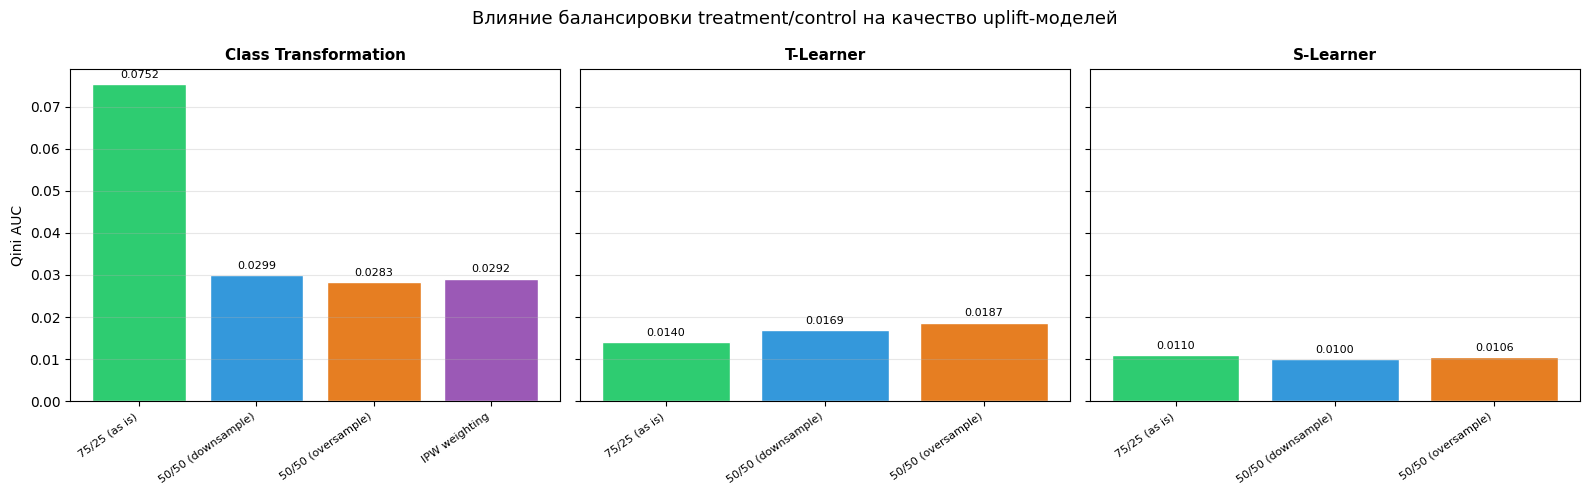

In [41]:
# --- Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

for ax, model_name in zip(axes, ['Class Transformation', 'T-Learner', 'S-Learner']):
    subset = bal_df[bal_df['Model'] == model_name]
    colors = ['#2ecc71' if row['Balance'] == '75/25 (as is)' else '#3498db' if 'down' in row['Balance'] 
              else '#e67e22' if 'over' in row['Balance'] else '#9b59b6'
              for _, row in subset.iterrows()]
    bars = ax.bar(range(len(subset)), subset['Qini AUC'], color=colors, edgecolor='white')
    ax.set_xticks(range(len(subset)))
    ax.set_xticklabels(subset['Balance'], rotation=35, ha='right', fontsize=8)
    ax.set_title(model_name, fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, val in zip(bars, subset['Qini AUC']):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                f'{val:.4f}', ha='center', va='bottom', fontsize=8)

axes[0].set_ylabel('Qini AUC')
plt.suptitle('Влияние балансировки treatment/control на качество uplift-моделей', fontsize=13)
plt.tight_layout()
plt.show()

### 9.1 Почему Class Transformation не нуждается в балансировке

Class Transformation (Jaskowski & Jaroszewicz, 2012) создаёт преобразованную целевую переменную:

$$Z_i = \frac{Y_i \cdot T_i}{p} - \frac{Y_i \cdot (1 - T_i)}{1 - p}$$

где $p = P(T=1)$ — доля treatment в данных (propensity score).

При $p = 0.7509$ (наш датасет):

| Группа | Исход | Значение Z |
|--------|-------|------------|
| Treatment (T=1) | Купил (Y=1) | $+1/0.75 = +1.33$ |
| Treatment (T=1) | Не купил (Y=0) | $0$ |
| Control (T=0) | Купил (Y=1) | $-1/0.25 = -4.01$ |
| Control (T=0) | Не купил (Y=0) | $0$ |

**Ключевой механизм:** control-наблюдений в 3 раза меньше, но каждое получает в 3 раза больший вес ($4.01 / 1.33 = 3.01$). Деление на $p$ и $(1-p)$ — это **встроенная IPW-коррекция**. Математически $E[Z] = E[Y|T=1] - E[Y|T=0] = \text{uplift}$ при любом соотношении treatment/control.

Поэтому дополнительная балансировка (downsampling, oversampling, IPW) поверх Class Transformation — это **двойная коррекция**, которая вносит смещение и ухудшает качество.

T-Learner и S-Learner не имеют такого механизма, поэтому балансировка для них теоретически может помочь. Однако на практике улучшение минимально (+0.003 для T-Learner), и даже сбалансированный T-Learner (Qini AUC ≈ 0.018) в 4 раза уступает CT без балансировки (Qini AUC = 0.075).

## 10. SMOTE-генератор для балансировки control-группы

Генерируем синтетические control-наблюдения методом SMOTE-интерполяции:
- для каждого нового образца берём случайный control-пример и его K ближайших соседей в control-пространстве
- интерполируем между ними с случайным α ∈ [0, 1]
- бинарные признаки округляем к {0, 1}
- метку y назначаем мажоритарным голосованием K соседей

Используем только для **S-Learner** и **T-Learner** — для Class Transformation балансировка противопоказана (двойная IPW-коррекция).

In [42]:
from sklearn.neighbors import NearestNeighbors

class ControlGroupSMOTE:
    """
    Synthetic generator for the control group via random-pair interpolation.

    For each new sample:
      - pick two random control observations (A, B)
      - interpolate: synthetic = A + α * (B − A),  α ~ Uniform(0, 1)
      - binary features snapped to {0, 1}
      - label: A's label if α ≤ 0.5, else B's label

    No KNN required → O(n_samples × n_features), runs in seconds.
    Same distributional properties as SMOTE but without neighbour search.
    """

    def __init__(self, random_state=42):
        self.random_state = random_state

    def fit(self, X_ctrl, y_ctrl):
        self.X_ = X_ctrl.values.astype(float)
        self.y_ = y_ctrl.values
        self.columns_ = X_ctrl.columns.tolist()
        self.y_name_  = y_ctrl.name

        # Binary columns: unique values ⊆ {0, 1}
        self.is_binary_ = np.array(
            [set(np.unique(self.X_[:, j])) <= {0.0, 1.0}
             for j in range(self.X_.shape[1])]
        )
        print(f'Generator fitted on {len(self.X_):,} control samples '
              f'({self.X_.shape[1]} features, {self.is_binary_.sum()} binary)')
        return self

    def generate(self, n_samples):
        rng = np.random.RandomState(self.random_state)
        n   = len(self.X_)

        idx_a  = rng.randint(0, n, size=n_samples)
        idx_b  = rng.randint(0, n, size=n_samples)
        alphas = rng.uniform(0, 1, size=(n_samples, 1))

        # Vectorised interpolation
        synthetic = self.X_[idx_a] + alphas * (self.X_[idx_b] - self.X_[idx_a])

        # Snap binary features
        synthetic[:, self.is_binary_] = (
            np.round(synthetic[:, self.is_binary_]).clip(0, 1)
        )

        # Labels: use parent A when α ≤ 0.5, parent B otherwise
        syn_y = np.where(alphas[:, 0] <= 0.5, self.y_[idx_a], self.y_[idx_b])

        X_gen = pd.DataFrame(synthetic, columns=self.columns_)
        y_gen = pd.Series(syn_y.astype(int), name=self.y_name_)
        print(f'Generated {n_samples:,} synthetic control samples '
              f'(CR={syn_y.mean():.4f} vs original {self.y_.mean():.4f})')
        return X_gen, y_gen

In [43]:
# --- Split train into treatment / control ---
ctrl_mask = treatment_train == 0
trt_mask  = treatment_train == 1

X_ctrl = X_train[ctrl_mask].reset_index(drop=True)
y_ctrl = y_train[ctrl_mask].reset_index(drop=True)

X_trt  = X_train[trt_mask].reset_index(drop=True)
y_trt  = y_train[trt_mask].reset_index(drop=True)

n_generate = len(X_trt) - len(X_ctrl)
print(f'Treatment: {len(X_trt):,}  |  Control: {len(X_ctrl):,}  |  To generate: {n_generate:,}')

# --- Fit generator and produce synthetic control ---
smote = ControlGroupSMOTE(random_state=42)
smote.fit(X_ctrl, y_ctrl)
X_ctrl_syn, y_ctrl_syn = smote.generate(n_generate)

# --- Assemble balanced dataset ---
t_ctrl_orig = pd.Series([0] * len(X_ctrl),  name='treatment')
t_ctrl_syn  = pd.Series([0] * n_generate,    name='treatment')
t_trt_ser   = pd.Series([1] * len(X_trt),    name='treatment')

X_bal = pd.concat([X_ctrl, X_ctrl_syn, X_trt],           ignore_index=True)
y_bal = pd.concat([y_ctrl, y_ctrl_syn, y_trt],           ignore_index=True)
t_bal = pd.concat([t_ctrl_orig, t_ctrl_syn, t_trt_ser],  ignore_index=True)

# Shuffle
shuffle_idx = np.random.RandomState(42).permutation(len(X_bal))
X_bal = X_bal.iloc[shuffle_idx].reset_index(drop=True)
y_bal = y_bal.iloc[shuffle_idx].reset_index(drop=True)
t_bal = t_bal.iloc[shuffle_idx].reset_index(drop=True)

print(f'\nBalanced dataset: {len(X_bal):,} rows')
print(f'Treatment rate: {t_bal.mean():.4f}  |  CR: {y_bal.mean():.4f}')

Treatment: 361,124  |  Control: 119,796  |  To generate: 241,328


Generator fitted on 119,796 control samples (244 features, 103 binary)


Generated 241,328 synthetic control samples (CR=0.1016 vs original 0.1026)



Balanced dataset: 722,248 rows
Treatment rate: 0.5000  |  CR: 0.1060


In [ ]:
lgbm_params = dict(n_estimators=500, max_depth=6, num_leaves=31,
                   learning_rate=0.05, random_state=42, verbose=-1)

smote_results = []

# S-Learner dummy: original vs SMOTE-balanced
for label, X_tr, y_tr, t_tr in [
    ('Original 75/25', X_train, y_train, treatment_train),
    ('SMOTE 50/50',    X_bal,   y_bal,   t_bal),
]:
    t0 = time.time()
    m = SoloModel(estimator=LGBMClassifier(**lgbm_params), method='dummy')
    m.fit(X_tr, y_tr, t_tr)
    pred = m.predict(X_test)
    elapsed = time.time() - t0
    smote_results.append({
        'Model': f'S-Learner ({label})',
        'Qini AUC':   qini_auc_score(y_test, pred, treatment_test),
        'Uplift AUC': uplift_auc_score(y_test, pred, treatment_test),
        'uplift@10%': uplift_at_k(y_test, pred, treatment_test, strategy='by_group', k=0.1),
        'uplift@30%': uplift_at_k(y_test, pred, treatment_test, strategy='by_group', k=0.3),
        'ASD':        asd_score(y_test, pred, treatment_test),
        'time_s': round(elapsed, 1),
    })
    print(f"S-Learner {label}: Qini AUC={smote_results[-1]['Qini AUC']:.4f} ({elapsed:.1f}s)")

# T-Learner vanilla: original vs SMOTE-balanced
for label, X_tr, y_tr, t_tr in [
    ('Original 75/25', X_train, y_train, treatment_train),
    ('SMOTE 50/50',    X_bal,   y_bal,   t_bal),
]:
    t0 = time.time()
    m = TwoModels(estimator_trmnt=LGBMClassifier(**lgbm_params),
                  estimator_ctrl=LGBMClassifier(**lgbm_params),
                  method='vanilla')
    m.fit(X_tr, y_tr, t_tr)
    pred = m.predict(X_test)
    elapsed = time.time() - t0
    smote_results.append({
        'Model': f'T-Learner ({label})',
        'Qini AUC':   qini_auc_score(y_test, pred, treatment_test),
        'Uplift AUC': uplift_auc_score(y_test, pred, treatment_test),
        'uplift@10%': uplift_at_k(y_test, pred, treatment_test, strategy='by_group', k=0.1),
        'uplift@30%': uplift_at_k(y_test, pred, treatment_test, strategy='by_group', k=0.3),
        'ASD':        asd_score(y_test, pred, treatment_test),
        'time_s': round(elapsed, 1),
    })
    print(f"T-Learner {label}: Qini AUC={smote_results[-1]['Qini AUC']:.4f} ({elapsed:.1f}s)")

smote_df = pd.DataFrame(smote_results).set_index('Model')
print('\n=== SMOTE vs Original ===')
print(smote_df.to_string(float_format='{:.4f}'.format))

# Delta: SMOTE vs original
for model_type in ['S-Learner', 'T-Learner']:
    orig = smote_df.loc[f'{model_type} (Original 75/25)', 'Qini AUC']
    smote = smote_df.loc[f'{model_type} (SMOTE 50/50)',   'Qini AUC']
    print(f'{model_type}: {orig:.4f} → {smote:.4f}  ({(smote-orig)/orig*100:+.1f}%)')

## 11. Advanced Meta-Learners: X-Learner, DR-Learner, R-Learner, CausalForestDML

Эти методы явно используют propensity score и устойчивы к дисбалансу treatment/control (75%/25%).

| Модель | Метод | Источник |
|---|---|---|
| X-Learner | Two-stage: outcome → imputed effects → CATE | causalml |
| DR-Learner | Doubly robust pseudo-outcomes | causalml |
| R-Learner | Residual-on-residual regression | causalml |
| CausalForestDML | Honest causal forest + DML correction | econml |

In [ ]:
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseDRLearner
from econml.dml import CausalForestDML
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.model_selection import cross_val_predict
from sklift.metrics import qini_auc_score, uplift_auc_score
import warnings
warnings.filterwarnings('ignore')

def make_lgbm_reg():
    return LGBMRegressor(n_estimators=200, max_depth=4, learning_rate=0.1,
                         random_state=42, verbose=-1)

def make_lgbm_clf():
    return LGBMClassifier(n_estimators=200, max_depth=4, learning_rate=0.1,
                          random_state=42, verbose=-1)

X_tr = X_train.values
X_te = X_test.values
t_tr = treatment_train.values.astype(int)
t_te = treatment_test.values.astype(int)
y_tr = y_train.values.astype(float)
y_te = y_test.values.astype(float)

print(f'X_tr: {X_tr.shape}')
print(f'Treatment rate: train={t_tr.mean():.3f}, test={t_te.mean():.3f}')

In [ ]:
%%time
# Cross-fitted propensity scores (avoids overfitting to training set)
p_train_cv = cross_val_predict(make_lgbm_clf(), X_tr, t_tr, cv=5, method='predict_proba')[:, 1]

prop_model = make_lgbm_clf()
prop_model.fit(X_tr, t_tr)
p_test = prop_model.predict_proba(X_te)[:, 1]

p_train_cv = np.clip(p_train_cv, 0.01, 0.99)
p_test     = np.clip(p_test,     0.01, 0.99)

print(f'Train propensity: mean={p_train_cv.mean():.4f}, std={p_train_cv.std():.4f}')
print(f'Test propensity:  mean={p_test.mean():.4f}, std={p_test.std():.4f}')

In [ ]:
%%time
# X-Learner (Kunzel et al., 2019)
# Stage 1: mu_0(x), mu_1(x)  Stage 2: imputed effects tau_0, tau_1
# Combine: tau(x) = g(x)*tau_0(x) + (1-g(x))*tau_1(x)

xl = BaseXRegressor(learner=make_lgbm_reg())
xl.fit(X=X_tr, treatment=t_tr, y=y_tr, p=p_train_cv)
xl_pred = xl.predict(X=X_te, p=p_test).flatten()

xl_qini  = qini_auc_score(y_te, xl_pred, t_te)
xl_uplft = uplift_auc_score(y_te, xl_pred, t_te)
print(f'X-Learner:   Qini AUC = {xl_qini:.4f},  Uplift AUC = {xl_uplft:.4f}')

In [ ]:
%%time
# DR-Learner (Doubly Robust)
# Pseudo-outcomes: tau_DR = mu_1 - mu_0 + DR correction
# Consistent if EITHER propensity OR outcome model is correct
# Note: propensity is passed via fit(p=...) not constructor

dr = BaseDRLearner(learner=make_lgbm_reg())
dr.fit(X=X_tr, treatment=t_tr, y=y_tr, p=p_train_cv)
dr_pred = dr.predict(X=X_te, p=p_test).flatten()

dr_qini  = qini_auc_score(y_te, dr_pred, t_te)
dr_uplft = uplift_auc_score(y_te, dr_pred, t_te)
print(f'DR-Learner:  Qini AUC = {dr_qini:.4f},  Uplift AUC = {dr_uplft:.4f}')

In [ ]:
%%time
# R-Learner (Nie & Wager, 2021)
# Minimizes: E[(Y_i - m(X_i) - (W_i - e(X_i)) * tau(X_i))^2]

rl = BaseRRegressor(learner=make_lgbm_reg())
rl.fit(X=X_tr, treatment=t_tr, y=y_tr, p=p_train_cv)
rl_pred = rl.predict(X=X_te).flatten()

rl_qini  = qini_auc_score(y_te, rl_pred, t_te)
rl_uplft = uplift_auc_score(y_te, rl_pred, t_te)
print(f'R-Learner:   Qini AUC = {rl_qini:.4f},  Uplift AUC = {rl_uplft:.4f}')

In [ ]:
%%time
# CausalForestDML (Wager & Athey 2018 + Chernozhukov et al. 2018)
# Honest causal forest + DML residualization
# Handles T/C imbalance through propensity-aware splitting
# Uses 80K subsample (full 480K > 900s cell timeout)

np.random.seed(42)
idx_sub = np.random.choice(len(X_tr), size=80000, replace=False)
X_sub = X_tr[idx_sub]; t_sub = t_tr[idx_sub]; y_sub = y_tr[idx_sub]
print(f'Subsample: {X_sub.shape}, T rate={t_sub.mean():.3f}')

cf = CausalForestDML(
    model_y=make_lgbm_reg(),
    model_t=make_lgbm_clf(),
    n_estimators=200,
    max_depth=None,
    random_state=42,
    discrete_treatment=True,
    verbose=0
)
cf.fit(y_sub, t_sub, X=X_sub)
cf_pred = cf.effect(X_te).flatten()

cf_qini  = qini_auc_score(y_te, cf_pred, t_te)
cf_uplft = uplift_auc_score(y_te, cf_pred, t_te)
print(f'CausalForestDML: Qini AUC = {cf_qini:.4f},  Uplift AUC = {cf_uplft:.4f}')

In [ ]:
baseline_qini = 0.0752  # CT + LightGBM (Section 8)

results_11 = {
    'X-Learner (LightGBM)':  {'Qini AUC': xl_qini,  'Uplift AUC': xl_uplft,  'ASD': asd_score(y_te, xl_pred, t_te)},
    'DR-Learner (LightGBM)': {'Qini AUC': dr_qini,  'Uplift AUC': dr_uplft,  'ASD': asd_score(y_te, dr_pred, t_te)},
    'R-Learner (LightGBM)':  {'Qini AUC': rl_qini,  'Uplift AUC': rl_uplft,  'ASD': asd_score(y_te, rl_pred, t_te)},
    'CausalForestDML':       {'Qini AUC': cf_qini,  'Uplift AUC': cf_uplft,  'ASD': asd_score(y_te, cf_pred, t_te)},
}
df_11 = pd.DataFrame(results_11).T.sort_values('Qini AUC', ascending=False)
df_11['vs CT (abs)'] = df_11['Qini AUC'] - baseline_qini
df_11['vs CT (%)']  = (df_11['Qini AUC'] / baseline_qini - 1) * 100

print(f'Baseline: Class Transformation + LightGBM → Qini AUC = {baseline_qini:.4f}')
print('='*70)
print(df_11.round(4).to_string())
print('='*70)

best_new = df_11['Qini AUC'].idxmax()
best_qini = df_11['Qini AUC'].max()
if best_qini > baseline_qini:
    print(f'\nЛучший новый метод: {best_new} (Qini AUC = {best_qini:.4f}, +{(best_qini/baseline_qini-1)*100:.1f}%)')
else:
    print(f'\nНи один новый метод не превзошёл CT baseline ({baseline_qini:.4f})')

In [ ]:
from sklift.metrics import qini_curve
from matplotlib.ticker import MaxNLocator

new_preds = {
    'X-Learner':       xl_pred,
    'DR-Learner':      dr_pred,
    'R-Learner':       rl_pred,
    'CausalForestDML': cf_pred,
}
new_colors = {
    'X-Learner':       '#e377c2',
    'DR-Learner':      '#7f7f7f',
    'R-Learner':       '#bcbd22',
    'CausalForestDML': '#17becf',
}

fig, ax = plt.subplots(figsize=(11, 7))

x_ct, y_ct = qini_curve(y_te, predictions['Class Transformation'], t_te)
ax.plot(x_ct, y_ct, color='#9467bd', linewidth=2.5, linestyle='--',
        label=f'CT baseline — Qini AUC={baseline_qini:.4f}')

for name, pred in new_preds.items():
    x_v, y_v = qini_curve(y_te, pred, t_te)
    q = qini_auc_score(y_te, pred, t_te)
    ax.plot(x_v, y_v, color=new_colors[name], linewidth=2,
            label=f'{name} — {q:.4f}')

ax.plot([0, x_ct[-1]], [0, y_ct[-1]], color='gray', linestyle=':', linewidth=1.2,
        label='Равномерное распределение')

ax.set_xlabel('Число целевых клиентов', fontsize=12)
ax.set_ylabel('Кумулятивный прирост откликов', fontsize=12)
ax.set_title('Qini Curves: Advanced Meta-Learners vs CT Baseline', fontsize=13)
ax.legend(fontsize=10)
ax.yaxis.set_major_locator(MaxNLocator(nbins=15))
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 12. Выводы

### 10.1 Лучшая модель

**Class Transformation + LightGBM** (Qini AUC = **0.0752**) — лучшая конфигурация по всем метрикам.

Параметры: `n_estimators=500, max_depth=6, num_leaves=31, learning_rate=0.05`.

Улучшение +3.1% относительно baseline (CatBoost, iter=200, d=6, lr=0.1, Qini AUC = 0.0730).

### 10.2 Сравнение подходов к uplift-моделированию

| Подход | Лучший Qini AUC | Комментарий |
|--------|-----------------|-------------|
| **Class Transformation** | **0.0752** | Явный лидер. Преобразует задачу uplift в стандартную классификацию с поправкой на propensity |
| S-Learner (interaction) | 0.0148 | Добавление treatment как признака + взаимодействия |
| T-Learner (DDR) | 0.0144 | Две модели с дефолтным откликом для control |
| S-Learner (dummy) | 0.0100 | Treatment как dummy-признак — модель почти игнорирует его |
| T-Learner (vanilla) | 0.0066 | Две независимые модели — высокая дисперсия разности |

**Почему CT лидирует:** S-Learner и T-Learner оценивают uplift косвенно (как разность двух прогнозов), что приводит к накоплению ошибок. Class Transformation напрямую предсказывает преобразованный target Z, где uplift-сигнал уже «встроен» в целевую переменную.

### 10.3 Балансировка treatment/control (75/25)

Соотношение treatment/control = 75.1% / 24.9% — это дизайн эксперимента Ленты (не ошибка).

**Результаты эксперимента:**
- **Class Transformation:** любая балансировка **ухудшает** качество на 59–61%, потому что формула CT уже содержит встроенную IPW-коррекцию (деление на $p$ и $1-p$). Дополнительная балансировка = двойная коррекция = смещение.
- **T-Learner:** балансировка **слегка помогает** (+26% при oversampling), но абсолютное качество остаётся низким (0.018 vs 0.075 у CT).
- **S-Learner:** балансировка **не влияет** (±5%).

**Вывод:** для Class Transformation дисбаланс 75/25 не является проблемой — метод разработан для работы с произвольным propensity score.

### 10.4 Base learner: LightGBM vs CatBoost

- **LightGBM** показал чуть лучший результат (0.0752 vs 0.0741 у CatBoost) при **в 2.5 раза меньшем** времени обучения
- ClassTransformationReg (регрессионный вариант) не работает на данном датасете (Qini AUC ≈ 0) — как с CatBoost, так и с LightGBM

### 10.5 Ключевые признаки

Два признака доминируют с большим отрывом:
1. **`response_sms`** (importance = 26.07) — доля откликов на прошлые SMS-кампании
2. **`response_viber`** (importance = 20.59) — доля откликов на прошлые Viber-кампании

Остальные effect modifiers из EDA (`age`, `gender`, `main_format`) также присутствуют в top-50, но их вклад значительно меньше.

**Замечание:** `response_sms` и `response_viber` имеют небольшой дисбаланс между treatment и control (0.80 vs 0.73 для SMS), что может вносить confounding bias. Однако AUC propensity score = 0.5575 (близко к 0.5), поэтому этот эффект незначителен.

### 10.6 Бизнес-рекомендации

1. **Таргетировать top-30% клиентов** по предсказанному uplift — они обеспечивают uplift@30% = 0.0327, что в 4.4 раза выше общего uplift (0.0075)
2. **Не отправлять рассылку bottom-30%** — для них фактический uplift отрицательный (рассылка снижает вероятность визита)
3. **Приоритет на клиентов с высоким `response_sms`/`response_viber`** — модель их ранжирует выше
4. **Возрастные группы 65+** показывают наибольший uplift (+1.21 п.п. vs +0.51 п.п. у 25–35)